<a href="https://colab.research.google.com/github/hansa31/GBM-analysis/blob/main/RF_regression_mRmR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#import xgboost as xgb

import shap

shap.initjs()

In [ ]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree

from sklearn.model_selection import StratifiedKFold

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

#import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GBM/PreProcess_data_with_Survival_days.csv')
df.head()

VOLUME_ET  VOLUME_NET  VOLUME_ED  VOLUME_TC  VOLUME_WT  VOLUME_BRAIN  \
0       1662         384      36268       2046      38314       1469432   
1       4362        4349      15723       8711      24434       1295721   
2      33404       48612      45798      82016     127814       1425843   
3      12114        7587      34086      19701      53787       1403429   
4      34538        7137      65653      41675     107328       1365237   

   VOLUME_ET_OVER_NET  VOLUME_ET_OVER_ED  VOLUME_NET_OVER_ED  \
0            4.328125           0.045826            0.010588   
1            1.002989           0.277428            0.276601   
2            0.687155           0.729377            1.061444   
3            1.596679           0.355395            0.222584   
4            4.839288           0.526069            0.108708   

   VOLUME_ET_over_TC  ...  TEXTURE_NGTDM_NET_FLAIR_Strength   TGM_p1  \
0            0.81232  ...                           61.3293  8.00000   
1            0.50075  ...                            3.5999  3.31250   
2            0.40729  ...                            0.8048  5.78125   
3            0.61489  ...                            4.7336  3.87500   
4            0.82875  ...                            2.4532  1.00000   

         TGM_dw  TGM_Cog_X_1  TGM_Cog_Y_1  TGM_Cog_Z_1   TGM_T_1        Age  \
0  7.500000e-07     0.178609     0.096256     0.052741    2.0000  56.208219   
1  1.000000e-09     0.077619     0.122900     0.094336   91.4736  61.526027   
2  1.000000e-09     0.132283     0.116006     0.096035  272.4290  18.975342   
3  1.000000e-09     0.100415     0.088249     0.096470  128.4680  33.887671   
4  5.730000e-08     0.106184     0.131952     0.096894  240.7780  54.986301   

   Survival  Survival_cat  
0       558          HIGH  
1       322           MID  
2       630          HIGH  
3       370           MID  
4        86           LOW  

[5 rows x 707 columns]

In the above df the Survival_cat is calculated as follows,

300,450

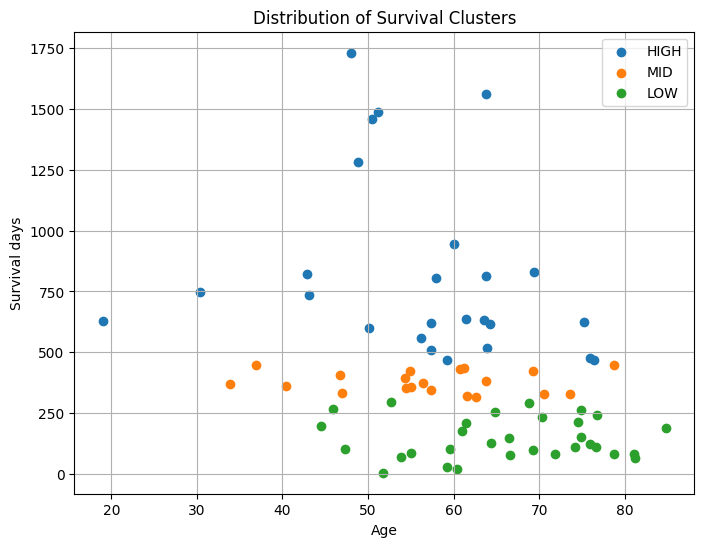

In [ ]:
# plot OS and AGE
# Scatter plot with color-coding by categorical variable
plt.figure(figsize=(8, 6))
#colors = plt.cm.get_cmap('tab10')(df['Survival_cat'].unique())  # Define color map

for i, category in enumerate(df['Survival_cat'].unique()):
    plt.scatter(df[df['Survival_cat'] == category]['Age'], df[df['Survival_cat'] == category]['Survival'], label=category)

plt.xlabel('Age')
plt.ylabel('Survival days')
plt.title('Distribution of Survival Clusters')
plt.legend()
plt.grid(True)
plt.show()


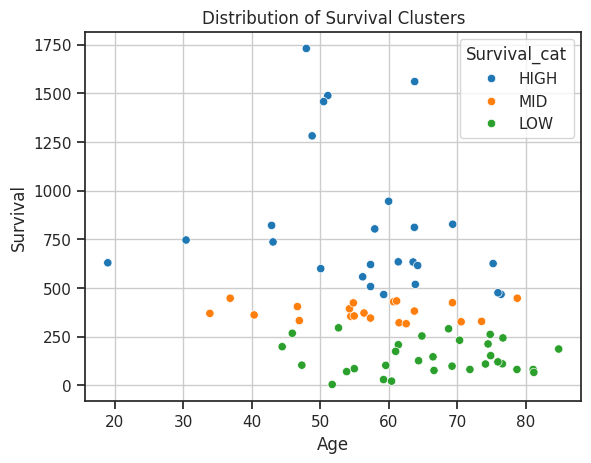

In [ ]:
sns.set_theme(style="ticks")  # Set Seaborn's default theme

# Create the scatter plot with color-coding based on 'Survival_cat'
sns.scatterplot(
    data=df,
    x="Age",
    y="Survival",
    hue="Survival_cat",
    palette="tab10",  # Use a distinctive color palette
    legend="full",  # Show full legend
)

# Customize the plot
plt.title("Distribution of Survival Clusters")
plt.grid(True)

plt.show()

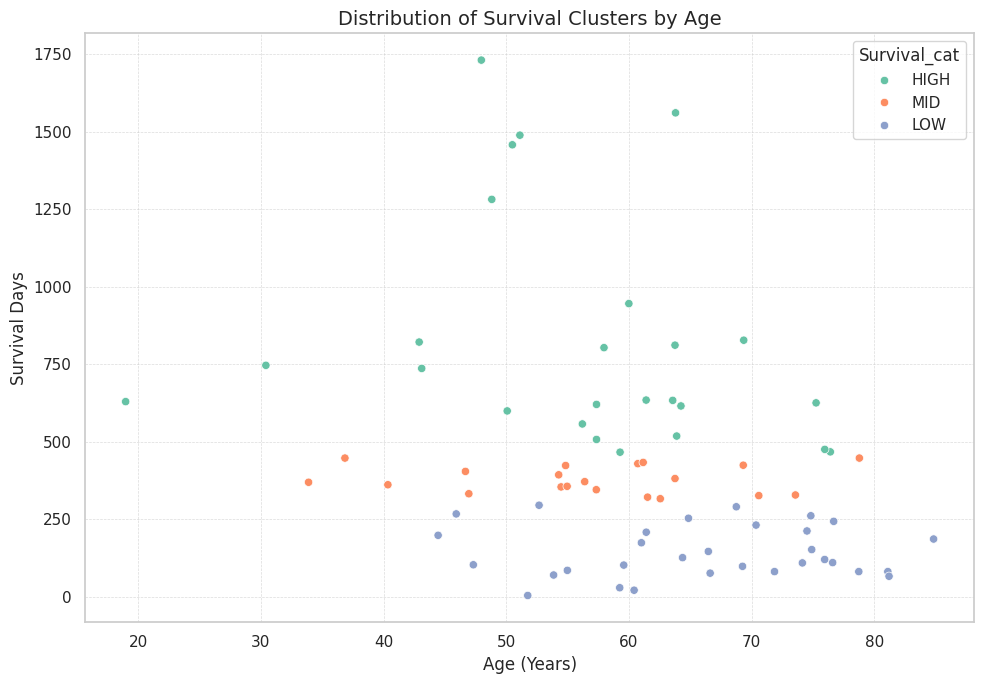

In [ ]:
# Set a larger figure size for better readability
plt.figure(figsize=(10, 7))

# Set Seaborn theme with a lighter background for aesthetics
sns.set_theme(style="whitegrid")

# Create the scatter plot with color-coding and size variation
sns.scatterplot(
    data=df,
    x="Age",
    y="Survival",
    hue="Survival_cat",
    palette="Set2",  # Visually appealing color scheme
    #size="marker_size",  # Add size variation based on a column (replace with desired column)
    #size_norm=(df["marker_size"].min(), df["marker_size"].max()),  # Normalize size based on column values
    legend="full",
)

# Customize the plot with informative labels, title, and grid
plt.xlabel("Age (Years)", fontsize=12)
plt.ylabel("Survival Days", fontsize=12)
plt.title("Distribution of Survival Clusters by Age", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Adjust grid style for better appearance

# Rotate x-axis labels for better readability if many categories
plt.xticks(rotation=45) if df["Survival_cat"].nunique() > 5 else plt.xticks()

# Show the plot
plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# take x data and y data from the df_noAge, and convert them to numpy arrays, y is the last column which is catogorical
X = df.iloc[:, :-2].values
y = df.iloc[:, -2].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(76, 705)

In [ ]:
y_labels = df.iloc[:,-1].values

In [ ]:
y_labels

array(['HIGH', 'MID', 'HIGH', 'MID', 'LOW', 'MID', 'LOW', 'LOW', 'MID',
       'LOW', 'LOW', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'LOW', 'HIGH', 'MID',
       'HIGH', 'LOW', 'LOW', 'MID', 'HIGH', 'HIGH', 'MID', 'LOW', 'LOW',
       'LOW', 'MID', 'MID', 'LOW', 'HIGH', 'LOW', 'HIGH', 'LOW', 'HIGH',
       'MID', 'MID', 'HIGH', 'LOW', 'MID', 'HIGH', 'HIGH', 'LOW', 'HIGH',
       'LOW', 'HIGH', 'MID', 'LOW', 'MID', 'HIGH', 'MID', 'HIGH', 'MID',
       'LOW', 'HIGH', 'MID', 'LOW', 'HIGH', 'MID', 'LOW', 'LOW', 'MID',
       'LOW', 'LOW', 'LOW', 'LOW', 'HIGH', 'LOW', 'HIGH', 'LOW', 'MID',
       'HIGH', 'LOW', 'LOW', 'LOW'], dtype=object)

In [ ]:
y

array([ 558,  322,  630,  370,   86,  430,  110,  209,  448,  199,  291,
        600,  804,  634, 1561,  268,  822,  355, 1489,   82,  187,  394,
        812,  737,  362,   67,   71,  262,  424,  329,  104, 1731,  127,
        616,  111,  828,  317,  405,  621,  175,  357,  747,  946,  103,
        468,   82,  467,  425,   22,  382, 1282,  327,  635,  448,  296,
        626,  372,  121,  476,  333,   30,  232,  434,   99,    5,  213,
        244, 1458,   77,  508,   82,  346,  519,  254,  147,  153])

# Selecting Columns

['HISTO_ED_T1_Bin2',
 'TEXTURE_GLRLM_ED_T1Gd_RP',
 'TEXTURE_GLCM_ET_T2_Entropy',
 'Age',
 'HISTO_ET_T2_Bin10',
 'TEXTURE_NGTDM_ET_FLAIR_Busyness',
 'HISTO_ET_FLAIR_Bin5',
 'HISTO_ED_T1_Bin3',
 'HISTO_ET_T1_Bin6',
 'TEXTURE_NGTDM_ED_FLAIR_Strength',
 'TEXTURE_GLCM_ED_FLAIR_Correlation',
 'HISTO_ED_FLAIR_Bin1',
 'TEXTURE_GLSZM_NET_T1Gd_SZE',
 'TEXTURE_GLRLM_ED_T2_LGRE',
 'TEXTURE_GLCM_ED_FLAIR_Contrast',
 'HISTO_ET_FLAIR_Bin8',
 'TEXTURE_NGTDM_ED_FLAIR_Coarseness',
 'HISTO_ED_FLAIR_Bin2',
 'TEXTURE_GLSZM_ED_T1_SZLGE',
 'TEXTURE_NGTDM_ED_FLAIR_Contrast',
 'TEXTURE_GLSZM_NET_T1Gd_ZSN',
 'HISTO_NET_T1_Bin7',
 'HISTO_ET_FLAIR_Bin3',
 'HISTO_ED_T1Gd_Bin2',
 'HISTO_NET_T1Gd_Bin5']

In [ ]:
# Extract corresponding values using NumPy indexing
valid_columns = ['HISTO_ED_T1_Bin2',
 'TEXTURE_GLRLM_ED_T1Gd_RP',
 'TEXTURE_GLCM_ET_T2_Entropy',
 'Age',
 'HISTO_ET_T2_Bin10',
 'TEXTURE_NGTDM_ET_FLAIR_Busyness',
 'HISTO_ET_FLAIR_Bin5',
 'HISTO_ED_T1_Bin3',
 'HISTO_ET_T1_Bin6',
 'TEXTURE_NGTDM_ED_FLAIR_Strength',
 'TEXTURE_GLCM_ED_FLAIR_Correlation',
 'HISTO_ED_FLAIR_Bin1',
 'TEXTURE_GLSZM_NET_T1Gd_SZE',
 'TEXTURE_GLRLM_ED_T2_LGRE',
 'TEXTURE_GLCM_ED_FLAIR_Contrast',
 'HISTO_ET_FLAIR_Bin8',
 'TEXTURE_NGTDM_ED_FLAIR_Coarseness',
 'HISTO_ED_FLAIR_Bin2',
 'TEXTURE_GLSZM_ED_T1_SZLGE',
 'TEXTURE_NGTDM_ED_FLAIR_Contrast',
 'TEXTURE_GLSZM_NET_T1Gd_ZSN',
 'HISTO_NET_T1_Bin7',
 'HISTO_ET_FLAIR_Bin3',
 'HISTO_ED_T1Gd_Bin2',
 'HISTO_NET_T1Gd_Bin5']
selected_values = X_scaled[:, [df.columns.get_loc(col) for col in valid_columns]]

# Random Forest

In [ ]:
# helper function

def fitting(X_train,X_test,y_train, y_test, criterion, splitter, mdepth,
            minleaf, min_samples_split, feature_names, n_estimators):

    # Create training and testing samples
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Fit the model
    #model = tree.DecisionTreeRegressor(criterion=criterion,
     #                        splitter=splitter,
     #                        max_depth=mdepth,
      #                       min_samples_leaf=minleaf,
      #                       min_samples_split=min_samples_split,
       #                      random_state=42)

    model = RandomForestRegressor(criterion=criterion,
                             n_estimators=n_estimators,
                             max_depth=mdepth,
                             min_samples_leaf=minleaf,
                             min_samples_split=min_samples_split,
                             random_state=42)

    clf = model.fit(X_train, y_train)

    # Predict on test and training data
    pred_values_te = model.predict(X_test)
    pred_values_tr = model.predict(X_train)

    # Calculate MSE and R-squared for test data
    mse_te = mean_squared_error(y_test, pred_values_te)
    r2_te = r2_score(y_test, pred_values_te)

    # Calculate MSE and R-squared for training data
    mse_tr = mean_squared_error(y_train, pred_values_tr)
    r2_tr = r2_score(y_train, pred_values_tr)

    print('*************** Evaluation on Test Data ***************')
    print('Mean Squared Error: ', mse_te)
    print('R-squared: ', r2_te)
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Training Data ***************')
    print('Mean Squared Error: ', mse_tr)
    print('R-squared: ', r2_tr)
    print('--------------------------------------------------------')
    print("")



    # Return relevant data for chart plotting
    #return X_train, X_test, y_train, y_test, clf, graph
    return clf

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [4, 6, 8],  # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
}

# Create stratified KFold object
skf = KFold(n_splits=15, shuffle=True, random_state=42)

# Define the scoring metric (e.g., mean squared error for regression)
scorer = 'neg_mean_squared_error'  # Use 'neg_' for minimization

# Create and train the GridSearchCV model
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=skf, scoring=scorer)
grid_search.fit(selected_values, y)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model for prediction and classification
y_pred = best_model.predict(selected_values)
y_pred_labels = np.where(y_pred < 300, "LOW", np.where(y_pred >= 450, "HIGH", "MID"))


In [ ]:
score = accuracy_score(y_pred_labels, y_labels)
score

0.6973684210526315

In [ ]:
best_params

{'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
best_params

{'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 300}

FOLD 0 ******************************************
*************** Evaluation on Test Data ***************
Mean Squared Error:  48588.82833752437
R-squared:  0.133506460042783
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Mean Squared Error:  47367.3050220512
R-squared:  0.6627850028174844
--------------------------------------------------------

FOLD 1 ******************************************
*************** Evaluation on Test Data ***************
Mean Squared Error:  292972.45597880404
R-squared:  -0.21496842791511517
--------------------------------------------------------

*************** Evaluation on Training Data ***************
Mean Squared Error:  37576.16222495557
R-squared:  0.6176665847749297
--------------------------------------------------------

FOLD 2 ******************************************
*************** Evaluation on Test Data ***************
Mean Squared Error:  69717.24286979876
R-squared:

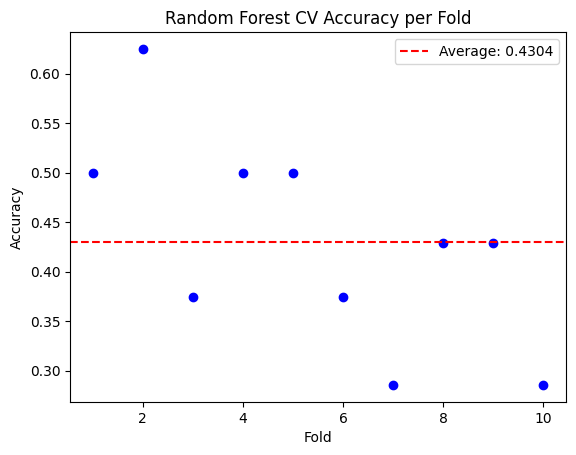

Average cross-validation accuracy: 0.4304


In [ ]:
# Define number of folds for cross-validation
n_folds = 10

# Stratified K-Fold cross-validation
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize empty lists to store scores and predictions
scores = []
y_pred = np.zeros_like(y)

# convert the predictions to labels and store them
y_pred_labels = []

# temp list
temp = []

# Empty list to hold the graph objects
graph_list = []

# Empty list to hold the models
models_list = []

# Plot setup
fig, ax = plt.subplots()

# Iterate over folds
for fold_id, (train_index, test_index) in enumerate(skf.split(selected_values, y)):

    print(f"FOLD {fold_id} ******************************************")
    # Split data into training and testing sets
    X_train, X_test = selected_values[train_index], selected_values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # for the labeled test set
    y_train_labels, y_test_labels = y_labels[train_index], y_labels[test_index]

    # Create and train the Random Forest model
    #model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed
    #model.fit(X_train, y_train)

    # Create the Decision tree model
    model = fitting(X_train, X_test, y_train, y_test, "squared_error", 'random',
                                                       mdepth=8,
                                                       minleaf=4,
                                                       min_samples_split = 2,
                                                       n_estimators = 300,
                                                       feature_names = valid_columns)

    #graph_list.append(graph)
    models_list.append(model)

    # Make predictions on the test set
    y_pred[test_index] = model.predict(X_test)

    # regression to classification
    low_threshold = 300
    high_threshold = 450

    #print(y_pred[test_index][0])


    # Classify predictions based on thresholds
    #y_pred_labels[test_index] = np.where(y_pred[test_index] < low_threshold, "LOW", np.where(y_pred[test_index] >= high_threshold, "HIGH", "MID"))
    temp = np.where(y_pred[test_index] < low_threshold, "LOW", np.where(y_pred[test_index] >= high_threshold, "HIGH", "MID"))

    # Evaluate the model using accuracy (replace with your desired metric)
    #from sklearn.metrics import accuracy_score
    #score = accuracy_score(y_test_labels, y_pred_labels[test_index])
    score = accuracy_score(y_test_labels, temp)
    scores.append(score)

    # Plot individual fold accuracy
    ax.plot([fold_id + 1], [score], marker='o', linestyle='-', color='b')

# Plot average accuracy line
avg_score = np.mean(scores)
ax.axhline(y=avg_score, color='r', linestyle='--', label=f'Average: {avg_score:.4f}')

# Customize plot
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest CV Accuracy per Fold')
ax.legend()
plt.show()

# Print the average cross-validation score
print(f"Average cross-validation accuracy: {np.mean(scores):.4f}")

Get the 2nd model for SHAP analysis

### Trying to plot CV losses

In [ ]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Create stratified KFold object
skf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric (e.g., mean squared error for regression)
scorer = 'neg_mean_squared_error'  # Use 'neg_' for minimization

# Create storage for CV losses
cv_losses = []

def plot_cv_losses(cv_results, grid_param_1, grid_param_2, label):
  # Extract fold losses
  fold_losses = cv_results['mean_test_score']

  # Calculate mean and standard deviation of fold losses
  mean_loss = np.mean(fold_losses)
  std_dev = np.std(fold_losses)

  # Plot losses with error bars
  plt.plot([grid_param_1], [mean_loss], marker='o', linestyle='-', label=label)
  plt.errorbar([grid_param_1], [mean_loss], yerr=std_dev, fmt='none', ecolor='b', capsize=7)

# Create and train the GridSearchCV model with loss plotting
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=skf, scoring=scorer)
grid_search.fit(selected_values, y)

# Get the best model and parameters (updated way)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Convert dict_values to a list for slicing
param_grid_values_list = list(grid_search.param_grid.values())

# Extract and plot CV losses for each parameter combination
cv_results = grid_search.cv_results_
print(cv_results)

for param_1, param_2, cv_result in zip(grid_search.param_grid.keys(),
                                       param_grid_values_list[1:],
                                       cv_results['mean_test_score']):
  plot_cv_losses(cv_result, param_1, param_2, f"{param_1},{param_2}")

# Finalize plot
plt.xlabel(list(grid_search.param_grid.keys())[0])  # Label based on first param
plt.ylabel('Mean Squared Error (Lower is better)')
plt.title('GridSearchCV - Mean Squared Error per Parameter Combination')
plt.legend()
plt.grid(True)
plt.show()

{'mean_fit_time': array([0.00069141, 0.00054085, 0.00055654, 0.00053749, 0.00054071,
       0.0005686 , 0.00071421, 0.00056896, 0.00053439, 0.00070136,
       0.00061636, 0.00064037, 0.00062823, 0.0006119 , 0.00060625,
       0.00056722, 0.00057888, 0.0005656 , 0.00073035, 0.0007055 ,
       0.00079229, 0.00062742, 0.00065324, 0.00064771, 0.00062022,
       0.00060561, 0.00057986]), 'std_fit_time': array([2.15293614e-04, 8.49001162e-06, 3.50081050e-05, 1.10360764e-05,
       1.92563264e-05, 5.16950036e-05, 1.56086662e-04, 8.62030192e-05,
       1.08107513e-05, 8.07282668e-05, 8.04414534e-06, 4.29232180e-05,
       4.67155638e-05, 1.83055947e-05, 4.67658879e-05, 7.93719048e-06,
       2.01022353e-05, 1.26766286e-05, 6.68014695e-05, 7.70255454e-05,
       2.38242166e-04, 2.17591930e-05, 6.71857845e-05, 9.36891009e-05,
       7.49093723e-05, 6.01592441e-05, 1.98960126e-05]), 'mean_score_time': array([0.00037246, 0.00029805, 0.00030122, 0.00030169, 0.00030062,
       0.00034804, 0.00045109

IndexError: invalid index to scalar variable.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Create stratified KFold object
skf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric (e.g., mean squared error for regression)
scorer = 'neg_mean_squared_error'  # Use 'neg_' for minimization

# Create storage for CV losses
cv_losses = []

def plot_cv_losses(cv_results, grid_param_1, grid_param_2, label):
  # Extract fold losses
  fold_losses = cv_results['mean_test_score']

  # Calculate mean and standard deviation of fold losses
  mean_loss = np.mean(fold_losses)
  std_dev = np.std(fold_losses)

  # Plot losses with error bars
  plt.plot([grid_param_1], [mean_loss], marker='o', linestyle='-', label=label)
  plt.errorbar([grid_param_1], [mean_loss], yerr=std_dev, fmt='none', ecolor='b', capsize=7)

# Create and train the GridSearchCV model with loss plotting
grid_search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid=param_grid, cv=skf, scoring=scorer)
grid_search.fit(X, y)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Extract and plot CV losses for each parameter combination
cv_results = grid_search.cv_results_
for param_1, param_2, cv_result in zip(grid_search.param_grid[grid_search.best_params_index_],
                                       grid_search.param_grid.values()[1:],
                                       cv_results['cv_results']):
  plot_cv_losses(cv_result, param_1, param_2, f"{param_1},{param_2}")

# Finalize plot
plt.xlabel(list(grid_search.param_grid.keys())[0])  # Label based on first param
plt.ylabel('Mean Squared Error (Lower is better)')
plt.title('GridSearchCV - Mean Squared Error per Parameter Combination')
plt.legend()
plt.grid(True)
plt.show()

# Use the best model for prediction and classification
#y_pred = best_model.predict(X)
#y_pred_labels = np.where(y_pred < 300, "LOW", np.where(y_pred >= 450, "HIGH", "MID"))

# Evaluate the model performance on unseen data (optional)
#from sklearn.metrics import r2_score

#accuracy = r2_score(y, y_pred)  # Use R-squared for regression accuracy
#print(f"Final Model R-squared (Accuracy): {accuracy:.4f}")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_index_'

# SHAP ANALYSIS - Decision Tree (25 Features)

In [ ]:
model_shap = models_list[1]
#Get shap values
explainer = shap.Explainer(model_shap,feature_names=valid_columns)
shap_values= explainer(selected_values)

print(np.shape(shap_values))

(76, 25)


## Individual Waterfall plots & Force plots

Can be used to determine how the model reacts to out of the context samples

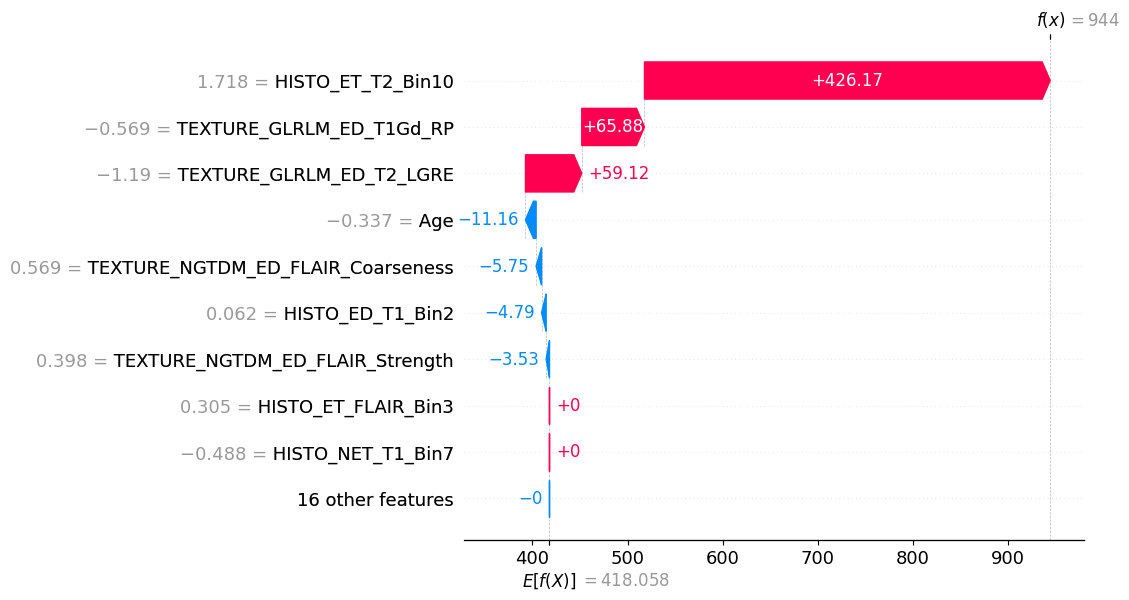

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()

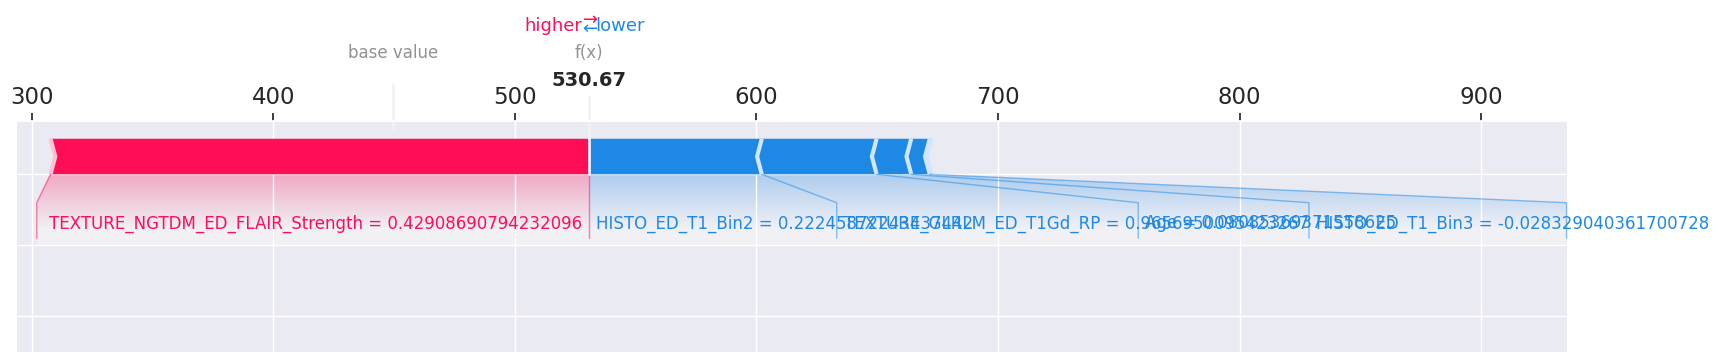

In [ ]:
shap.plots.force(shap_values[1],matplotlib=True)

### Stacked Force Plot

In [ ]:
shap.plots.force(shap_values[0:76], matplotlib=True)

NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!

## Mean SHAP plot

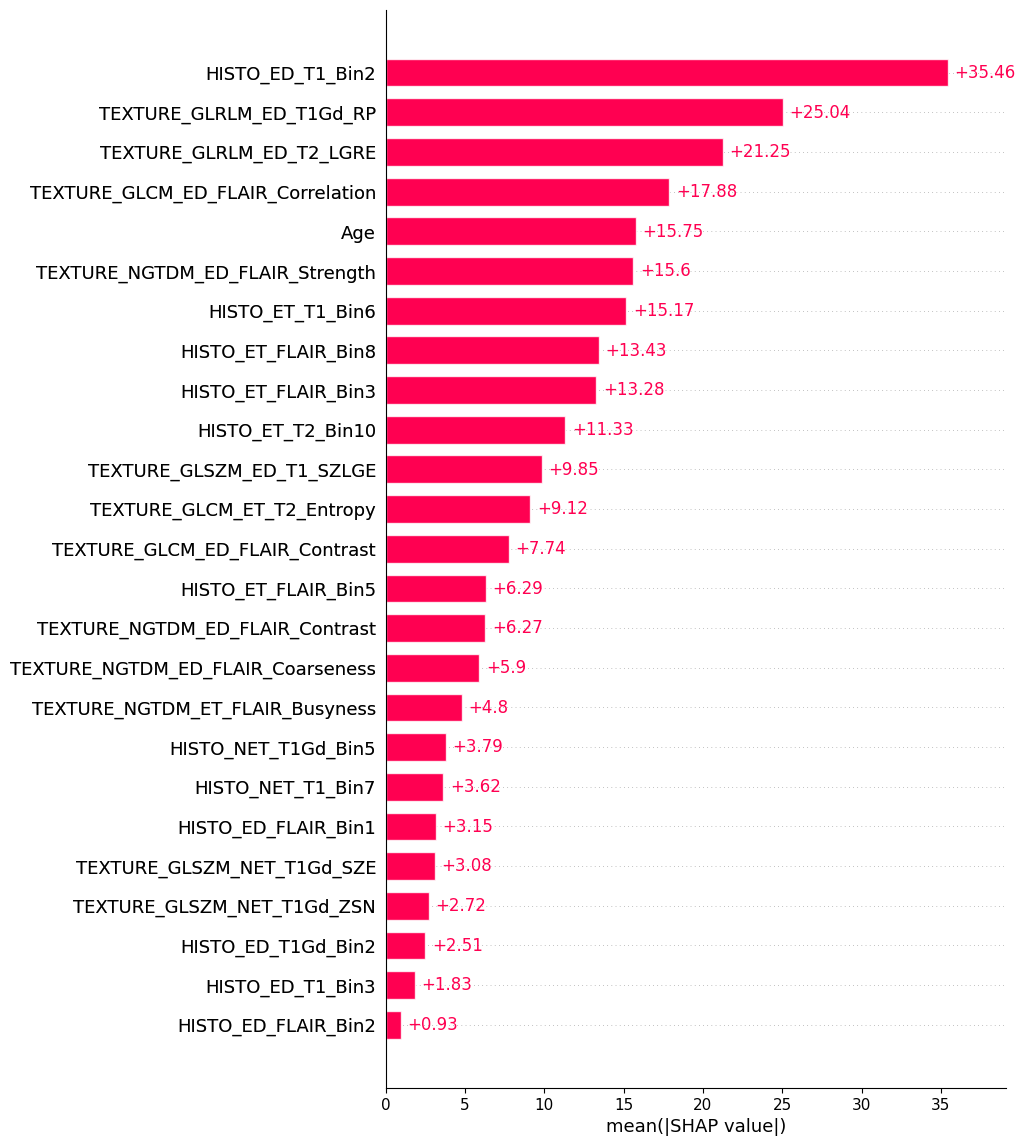

In [ ]:
shap.plots.bar(shap_values, max_display=25)

Here we can see that AGE is the most deciding factor. But in the previous individual plots texture features were prominent. Also there are 3 features that doesn't contribute at all.

## Beeswarm (Important)

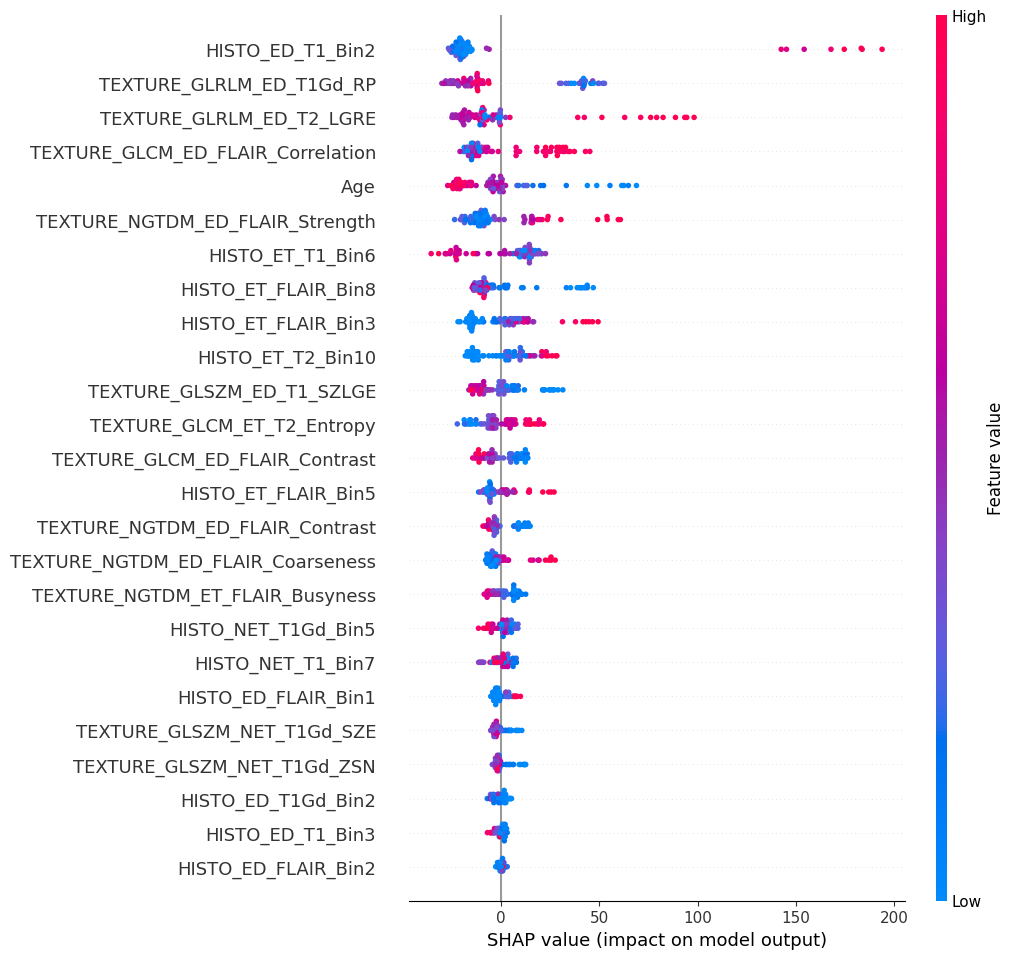

In [ ]:
shap.plots.beeswarm(shap_values,max_display=25)

Check this with the dataset

- There are some young pateints with high rate of survival. (4, 55, 43...) --> These samples are the ones that contributes to AGE being prominent. (Age values are normalized)

- It is visible that there is an inverse relationship 0, 4, 5, 6 and 1, 2, 3 features.

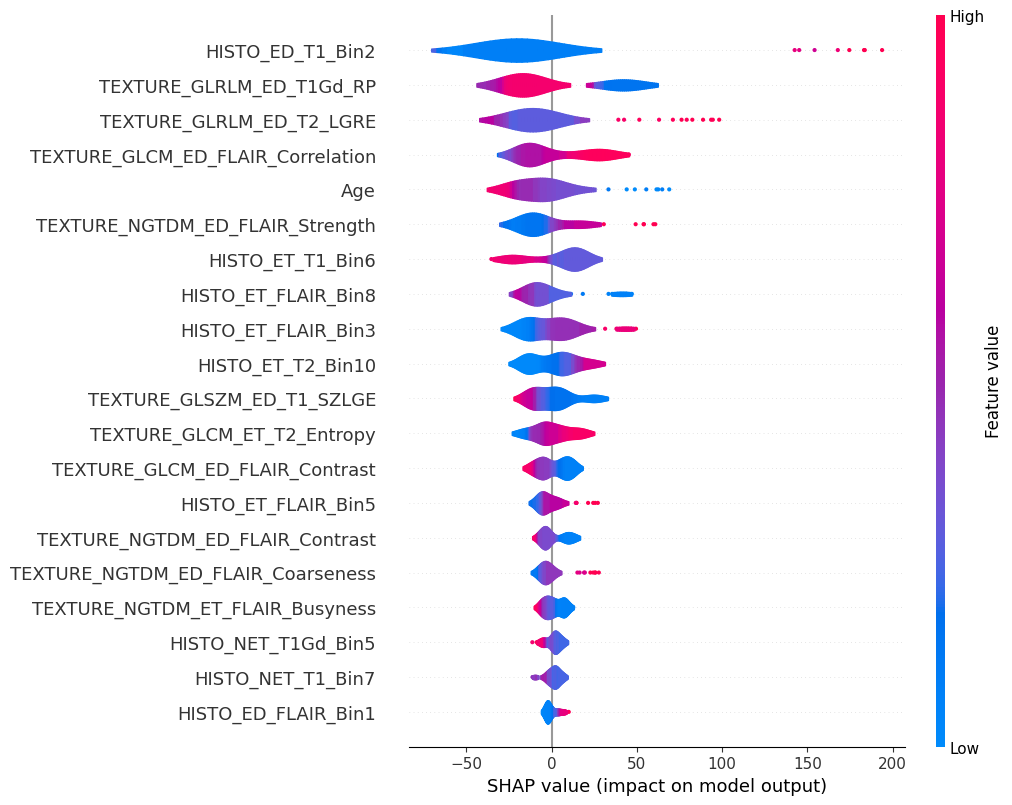

In [ ]:
shap.plots.violin(
    shap_values
)

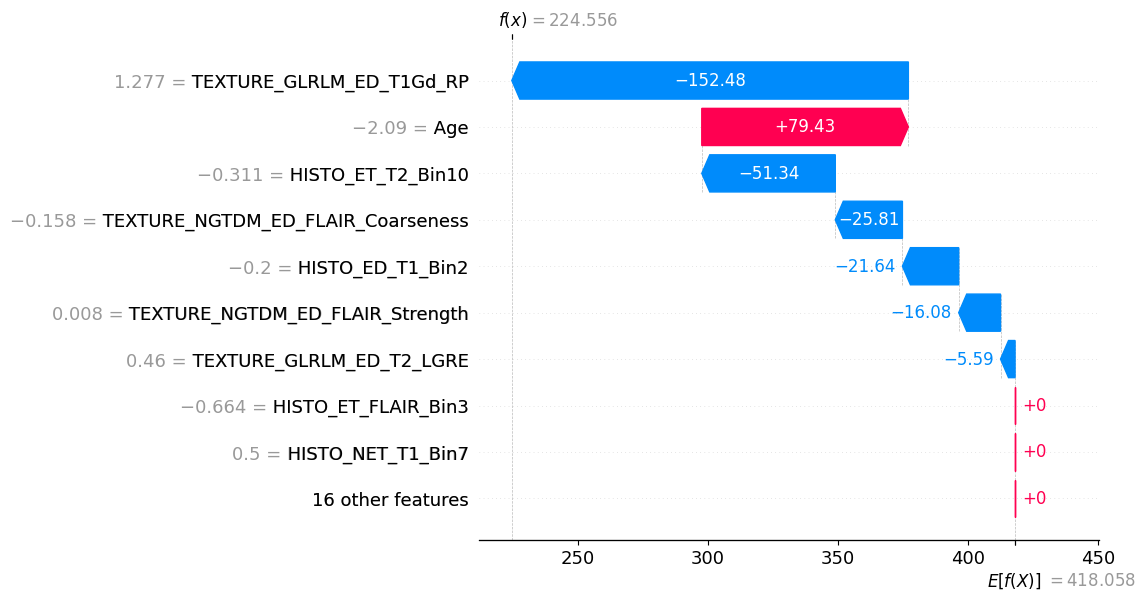

In [ ]:
shap.plots.waterfall(shap_values[3])

## Dependence plots

Selected 25 features: ['HISTO_ED_T1_Bin2', 'TEXTURE_GLRLM_ED_T1Gd_RP', 'TEXTURE_GLCM_ET_T2_Entropy', 'Age', 'HISTO_ET_T2_Bin10', 'TEXTURE_NGTDM_ET_FLAIR_Busyness', 'HISTO_ET_FLAIR_Bin5', 'HISTO_ED_T1_Bin3', 'HISTO_ET_T1_Bin6', 'TEXTURE_NGTDM_ED_FLAIR_Strength', 'TEXTURE_GLCM_ED_FLAIR_Correlation', 'HISTO_ED_FLAIR_Bin1', 'TEXTURE_GLSZM_NET_T1Gd_SZE', 'TEXTURE_GLRLM_ED_T2_LGRE', 'TEXTURE_GLCM_ED_FLAIR_Contrast', 'HISTO_ET_FLAIR_Bin8', 'TEXTURE_NGTDM_ED_FLAIR_Coarseness', 'HISTO_ED_FLAIR_Bin2', 'TEXTURE_GLSZM_ED_T1_SZLGE', 'TEXTURE_NGTDM_ED_FLAIR_Contrast', 'TEXTURE_GLSZM_NET_T1Gd_ZSN', 'HISTO_NET_T1_Bin7', 'HISTO_ET_FLAIR_Bin3', 'HISTO_ED_T1Gd_Bin2', 'HISTO_NET_T1Gd_Bin5']

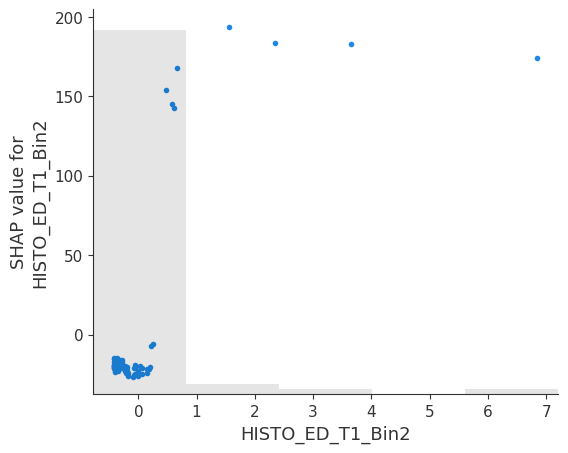

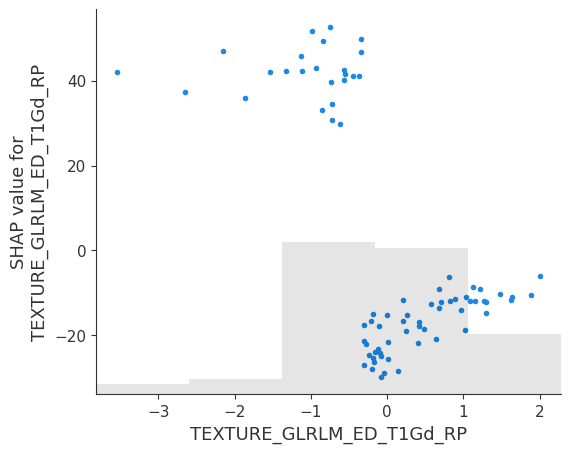

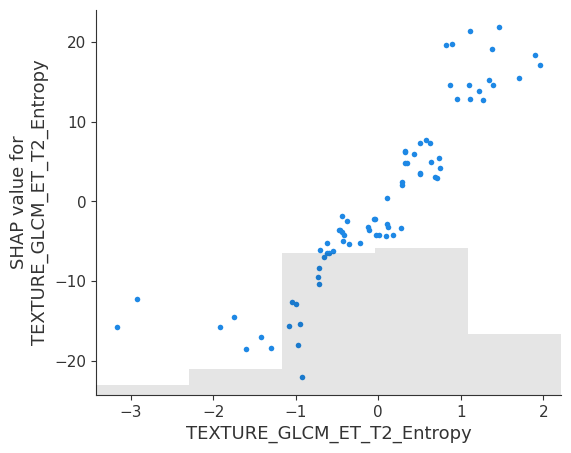

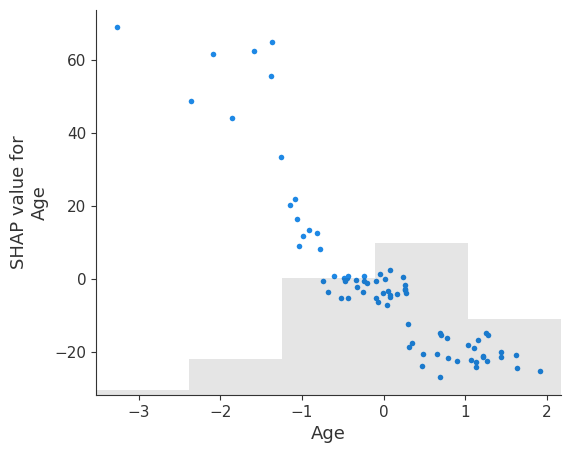

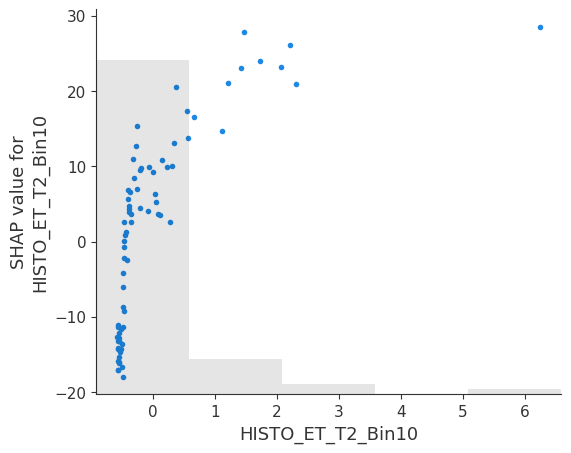

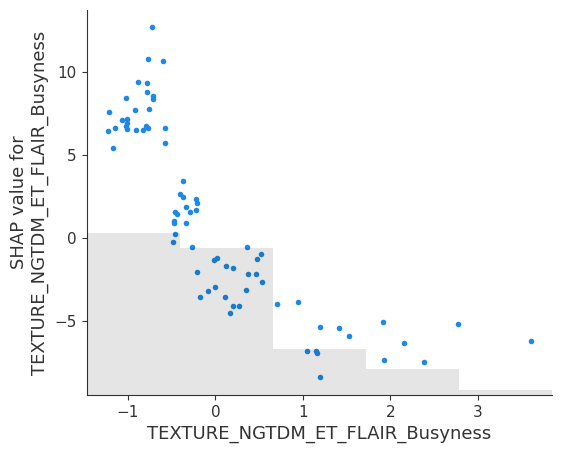

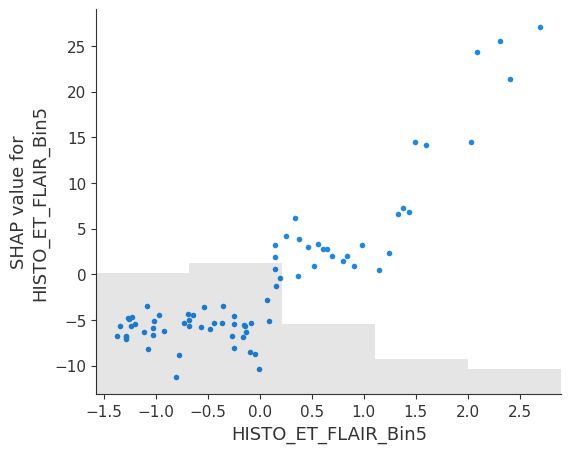

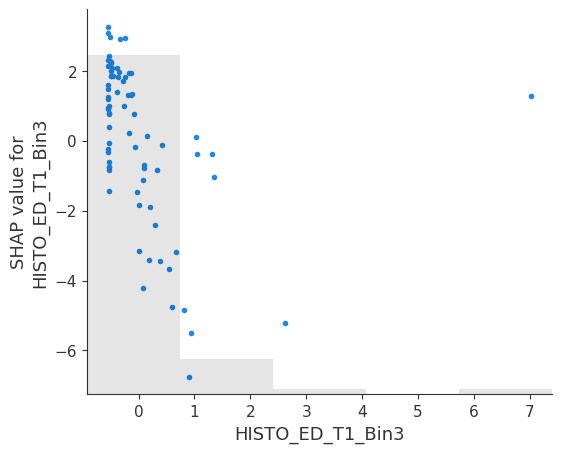

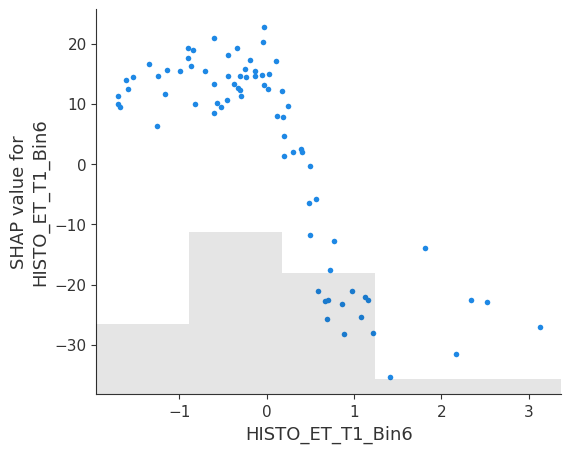

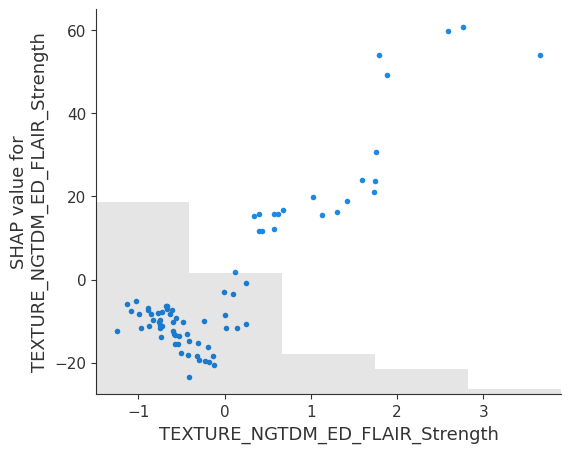

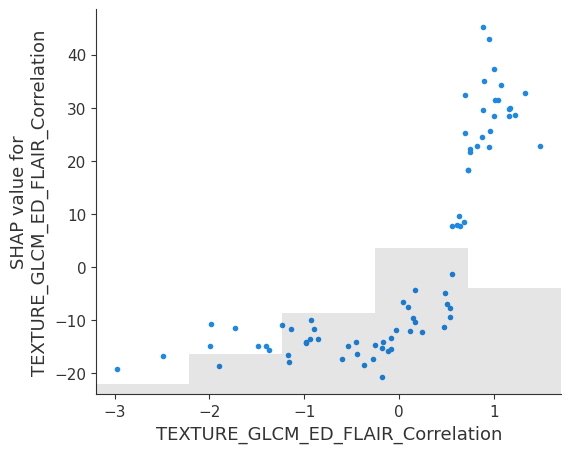

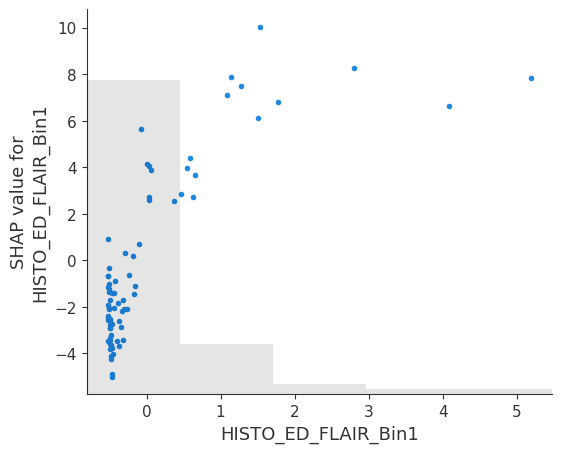

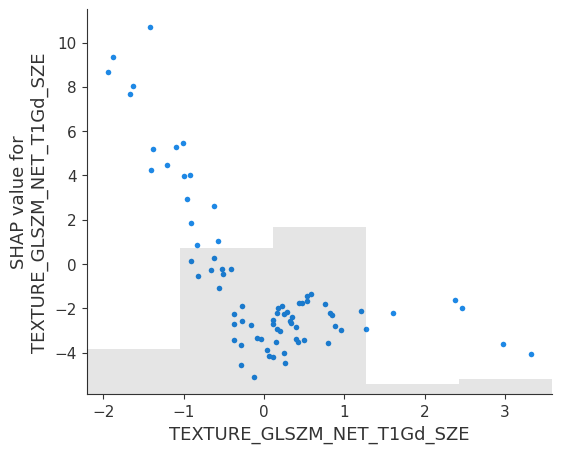

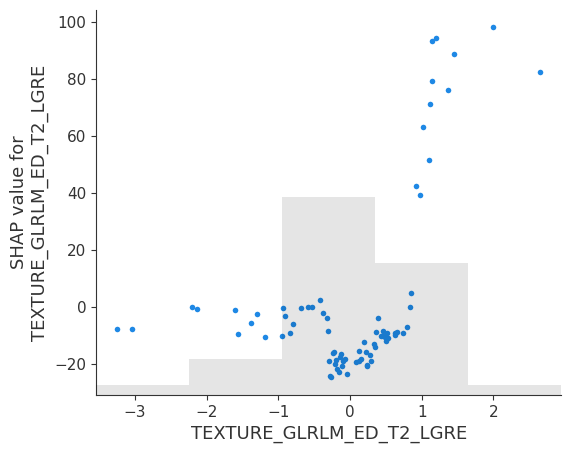

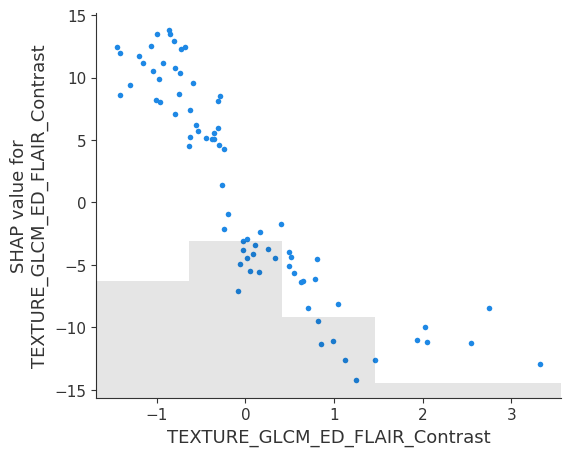

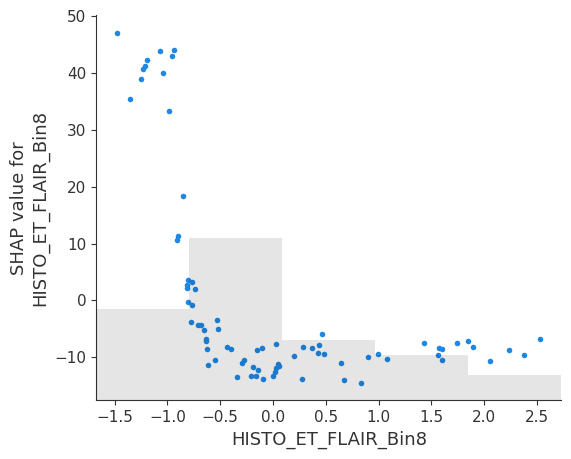

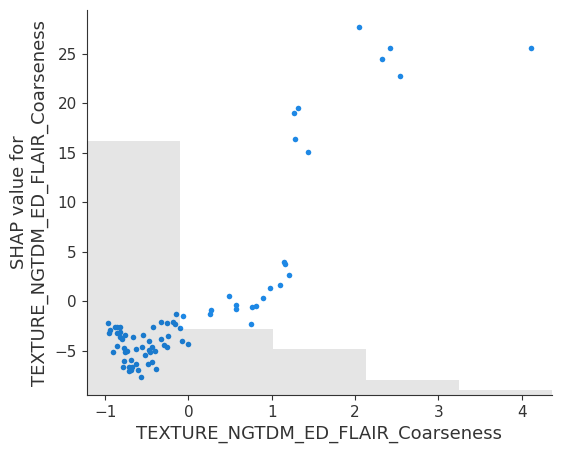

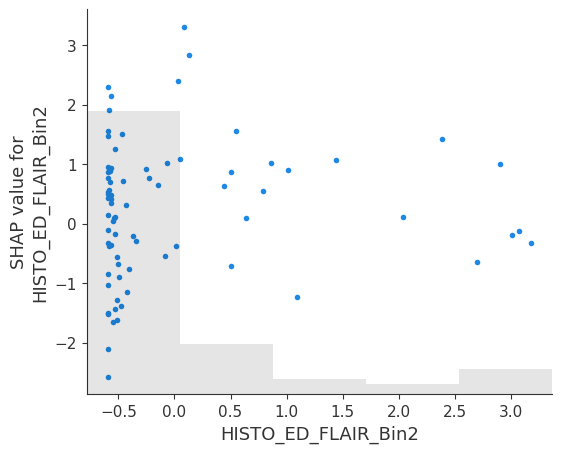

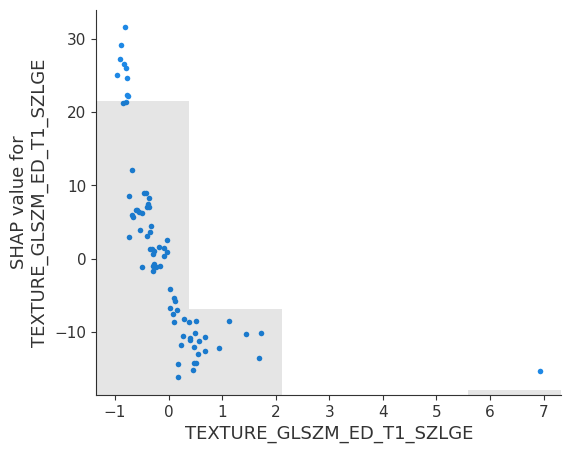

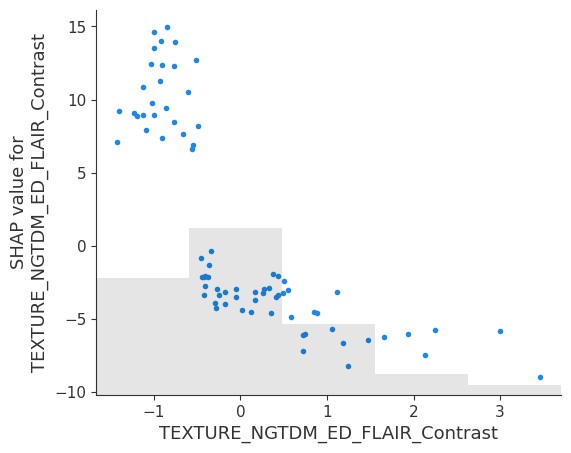

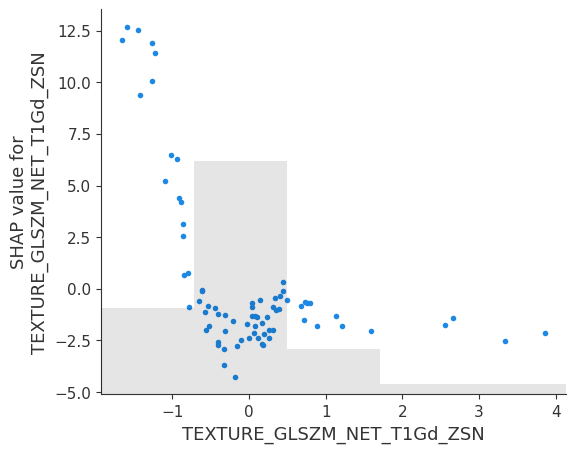

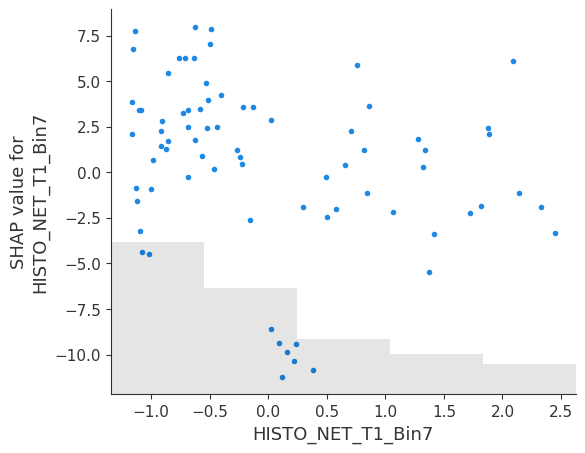

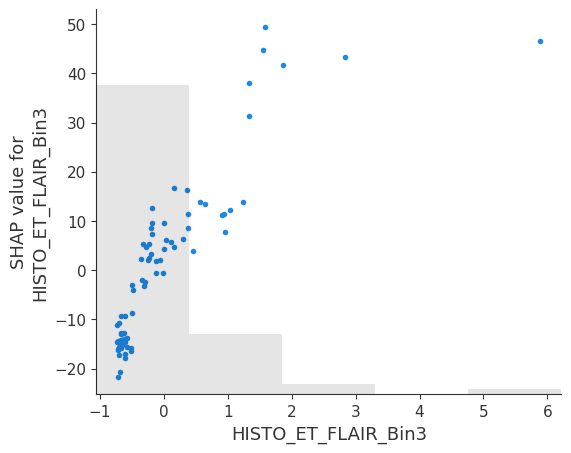

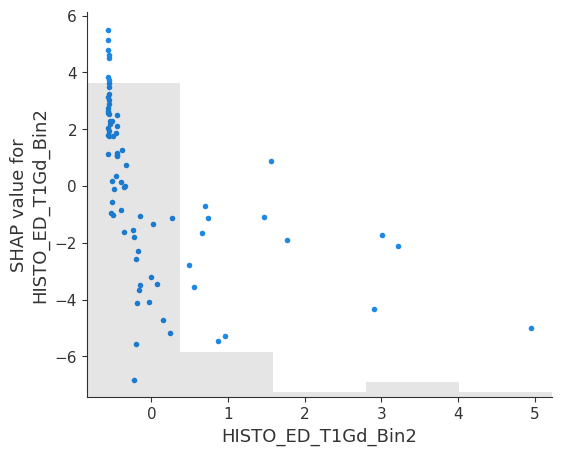

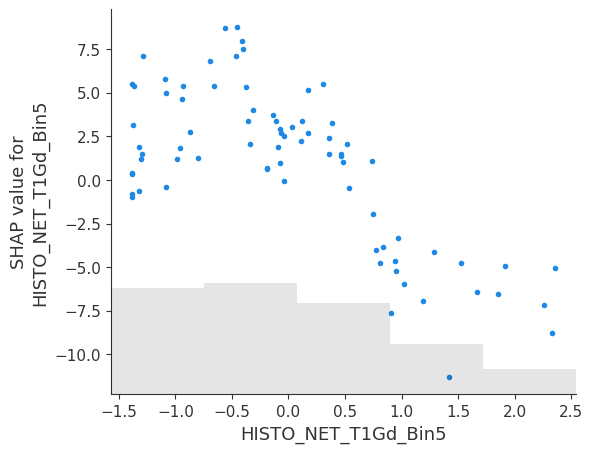

In [ ]:
for element in valid_columns:
  # Extract SHAP values for the current element (assuming column names match)
  shap_values_element = shap_values[:, element]

  # Create SHAP scatter plot for the current element
  shap.plots.scatter(shap_values_element)

  # Optional: Add a title or customize the plot using shap.plots.scatter arguments
  #shap.plots.scatter(shap_values_element, title=f"SHAP for {element}")

- IMPORTANT - These plots show the risk inflicting points

### Interaction Dependance Plots

HISTO_ET_T1_Bin6 and TEXTURE_GLRLM_ED_T1Gd_RP

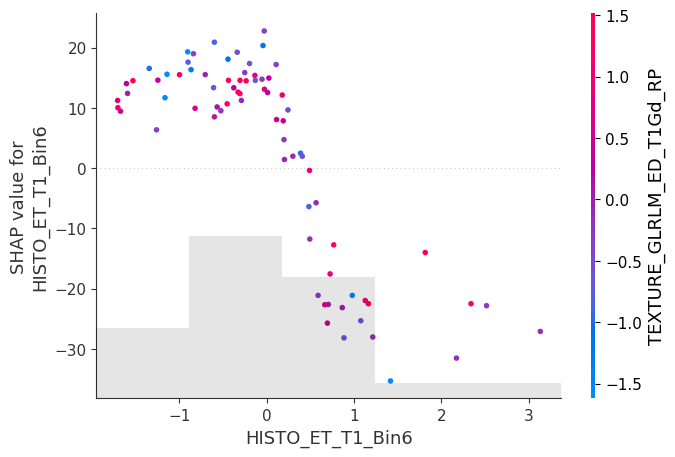

In [ ]:
shap.plots.scatter(shap_values[:,"HISTO_ET_T1_Bin6"], color=shap_values[:,"TEXTURE_GLRLM_ED_T1Gd_RP"])

- Can see a clear interaction here. Low values of Texture feature tends to increase SHAP more of low HISTO values.

TEXTURE_GLRLM_ED_T2_LGRE	TEXTURE_GLCM_ED_FLAIR_Correlation

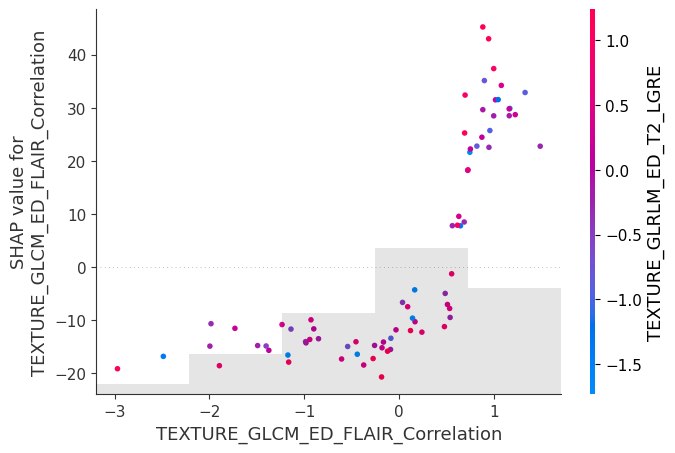

In [ ]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLCM_ED_FLAIR_Correlation"], color=shap_values[:,"TEXTURE_GLRLM_ED_T2_LGRE"])

TEXTURE_GLRLM_ED_T1Gd_RP	HISTO_ED_T1_Bin2

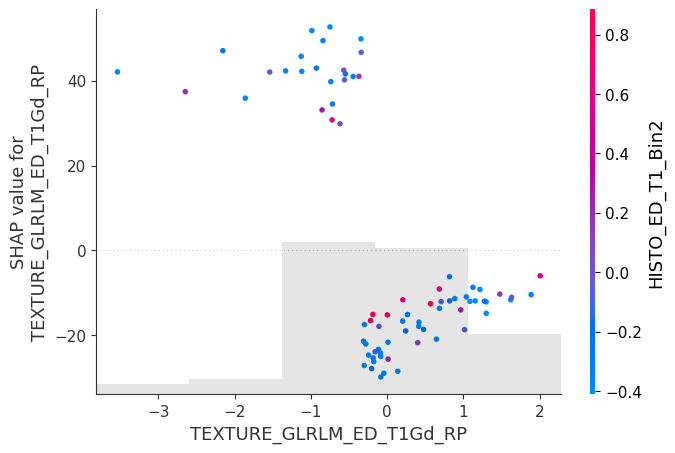

In [ ]:
shap.plots.scatter(shap_values[:,"TEXTURE_GLRLM_ED_T1Gd_RP"], color=shap_values[:,"HISTO_ED_T1_Bin2"])

- Some high values for HISTO feature tends to drag down the effect of texture feature.

TEXTURE_GLRLM_ED_T1Gd_RP	Age

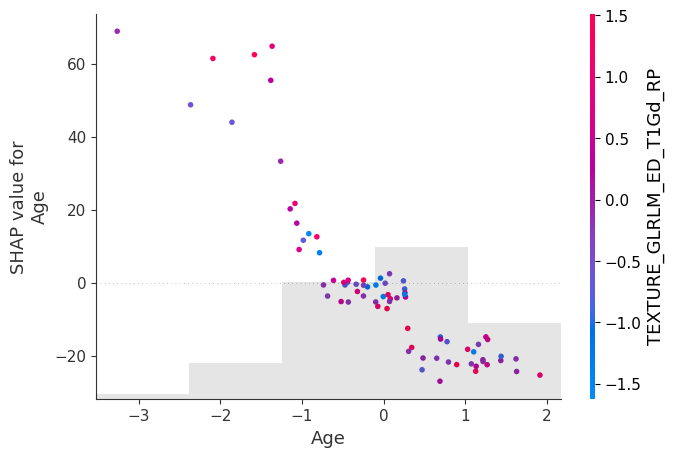

In [ ]:
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"TEXTURE_GLRLM_ED_T1Gd_RP"])

- can clearly be seen that high value of texture feature may increase the SHAP value for young patients.

HISTO_NET_T1_Bin7	HISTO_ET_T1_Bin6

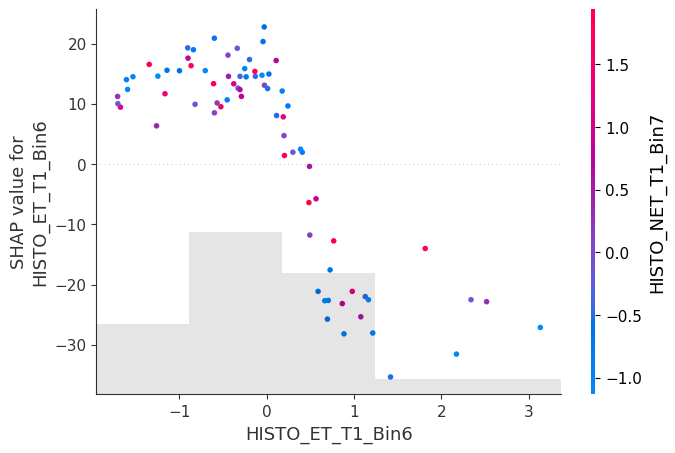

In [ ]:
shap.plots.scatter(shap_values[:,"HISTO_ET_T1_Bin6"], color=shap_values[:,"HISTO_NET_T1_Bin7"])

- Low values of HISTO_ET have high impact on the model. But this impact is dragged down by HISTO_NET high values

TEXTURE_NGTDM_ED_FLAIR_Strength	TEXTURE_GLRLM_ED_T1Gd_RP

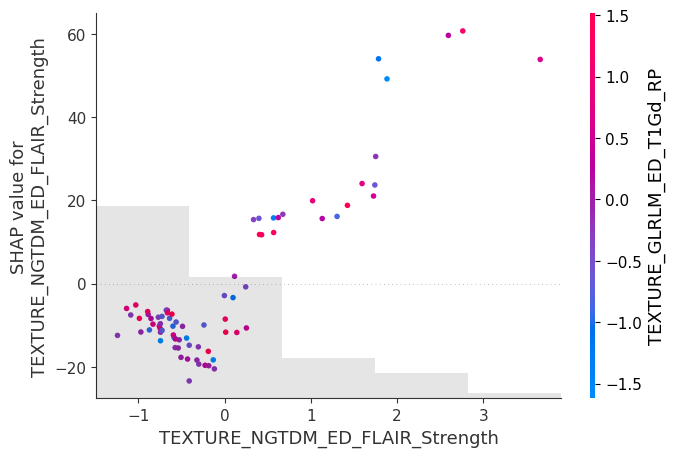

In [ ]:
shap.plots.scatter(shap_values[:,"TEXTURE_NGTDM_ED_FLAIR_Strength"], color=shap_values[:,"TEXTURE_GLRLM_ED_T1Gd_RP"])

Texture_NGTDM increases the effect on the model. However TEXTURE_GLRM also tends to increase the effect.

### Just doing some experiments

Checking how Age feature interacts with other features

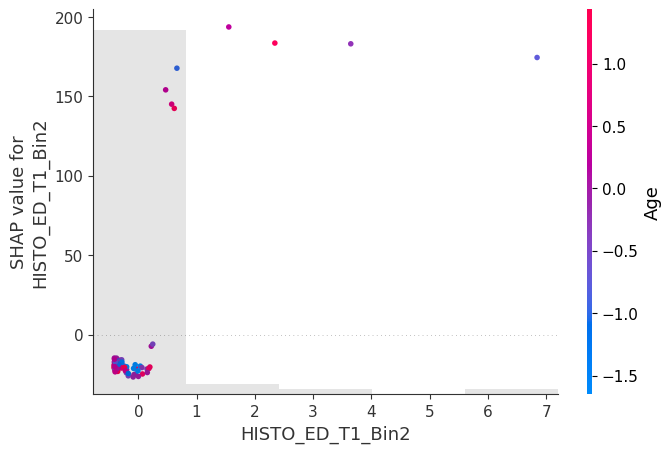

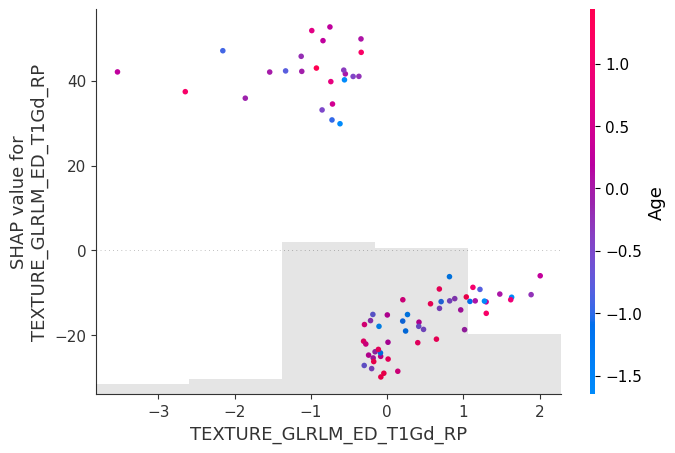

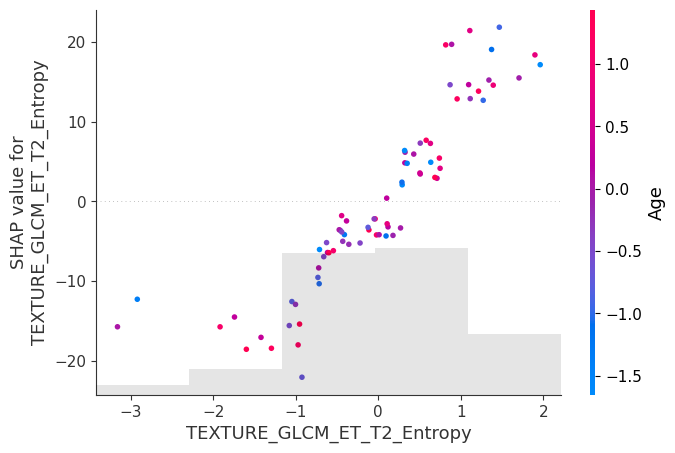

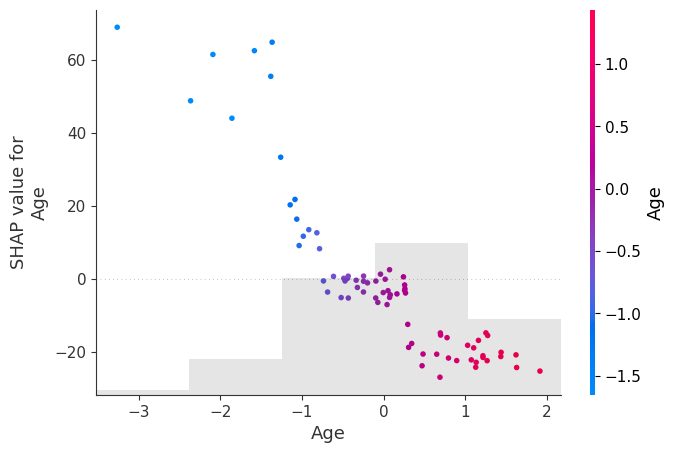

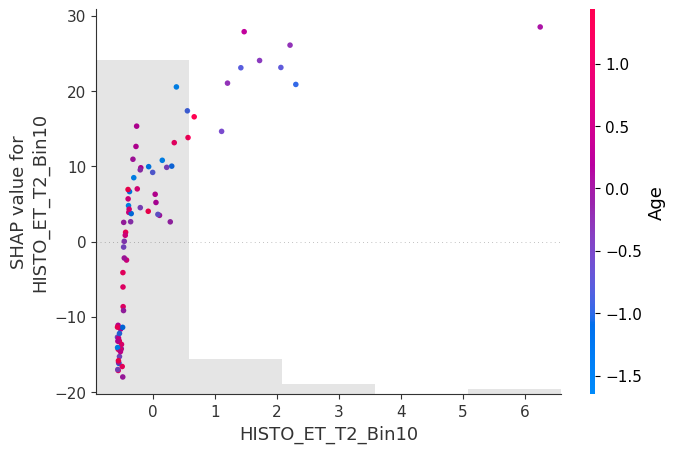

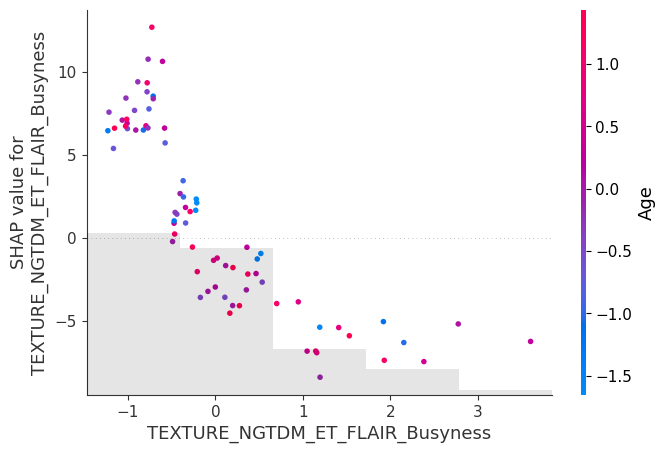

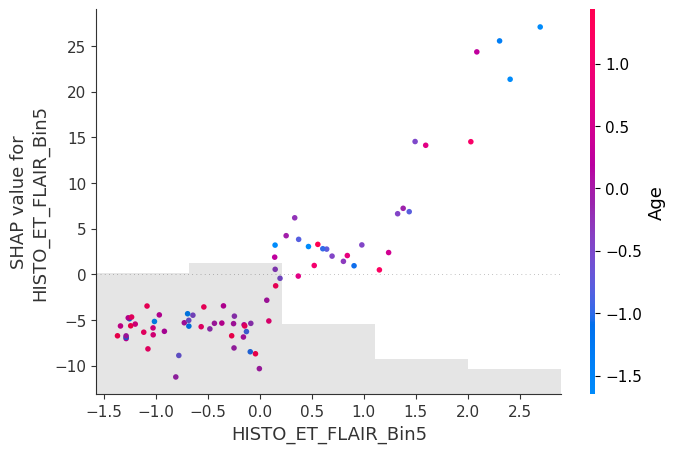

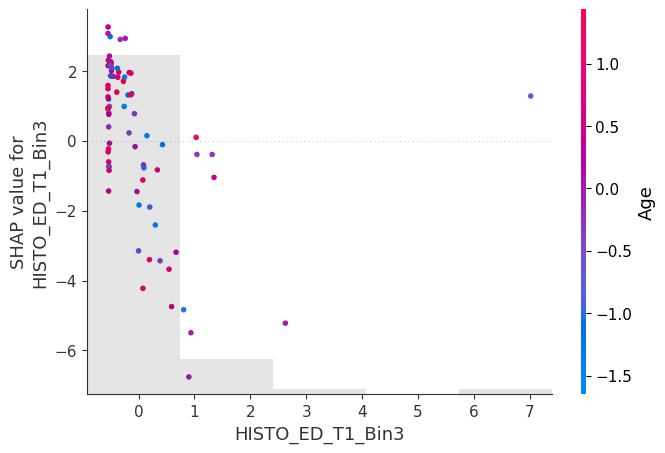

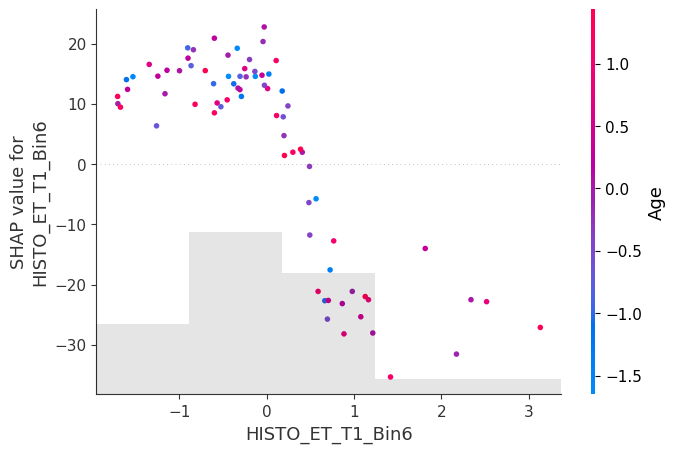

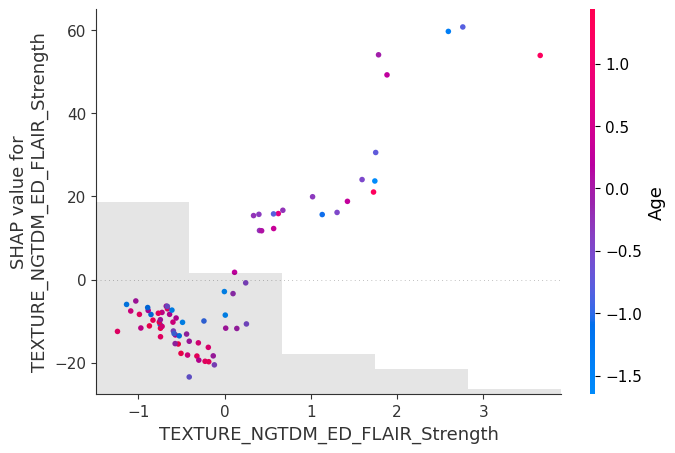

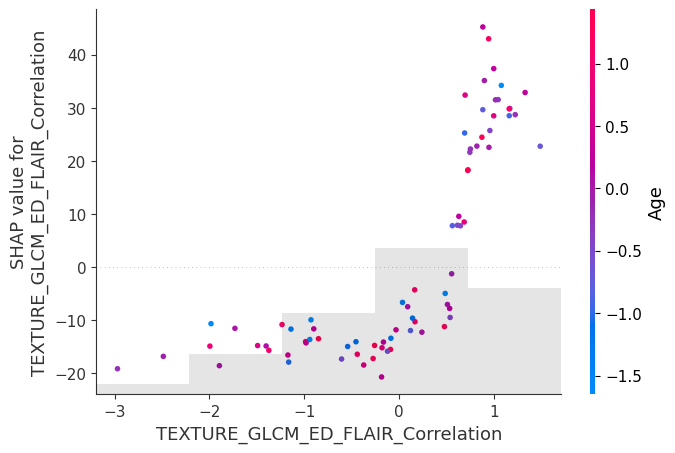

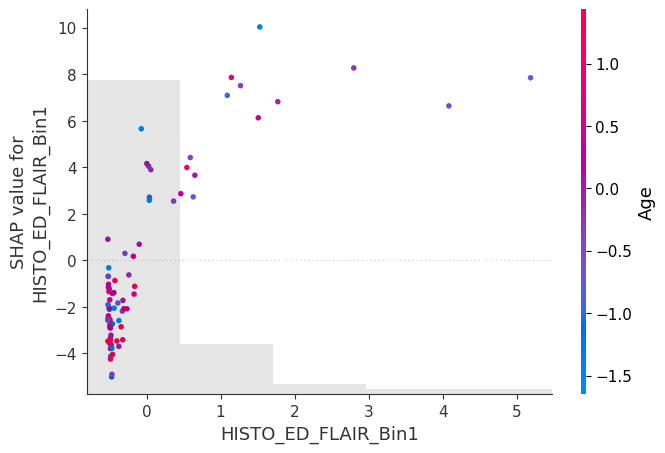

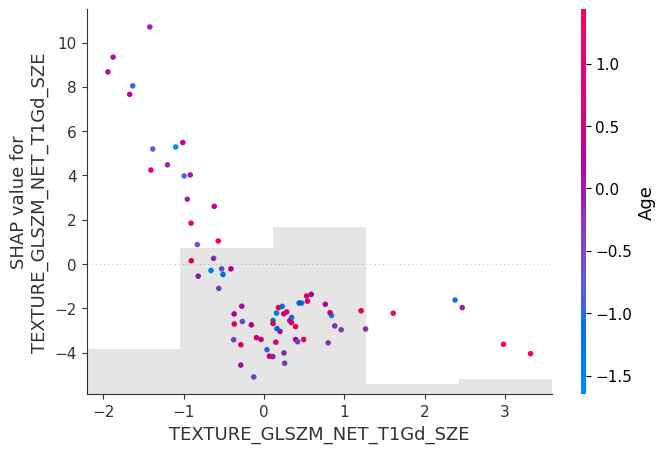

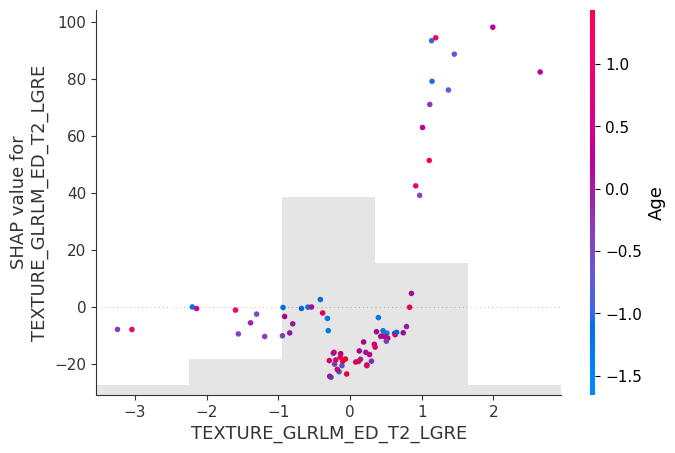

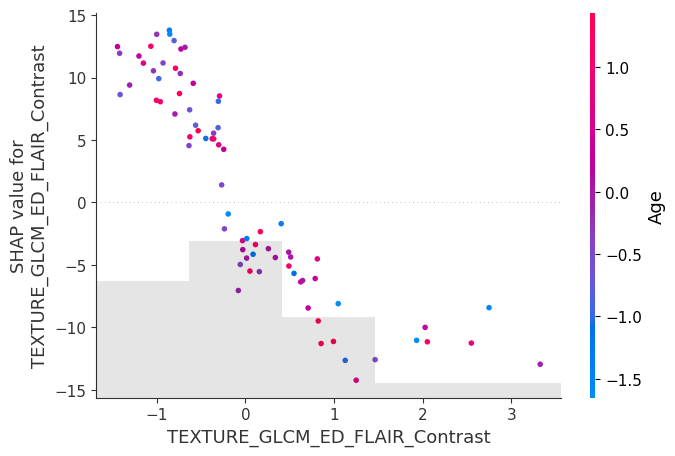

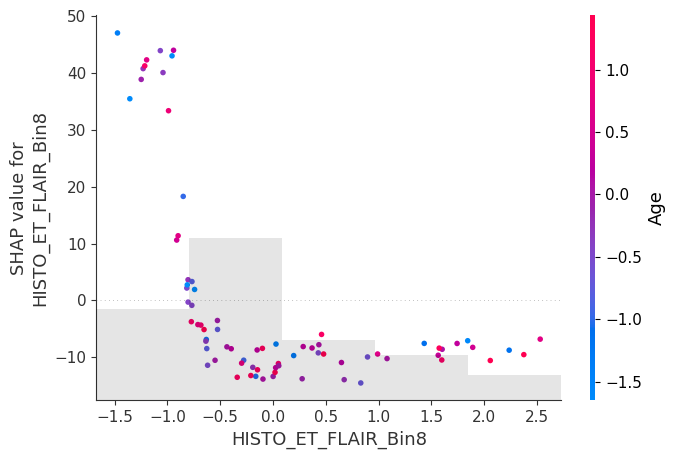

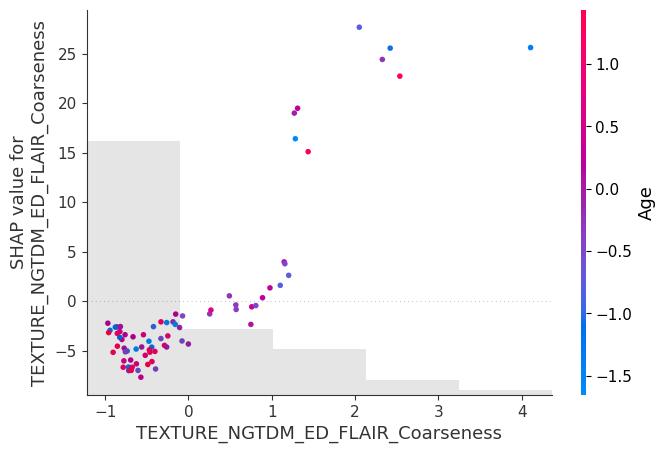

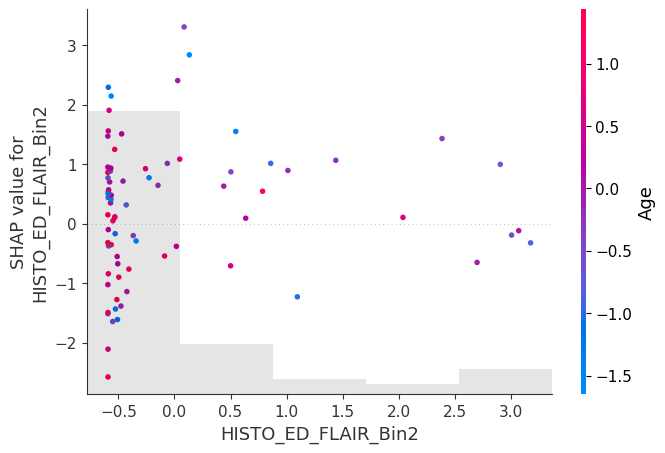

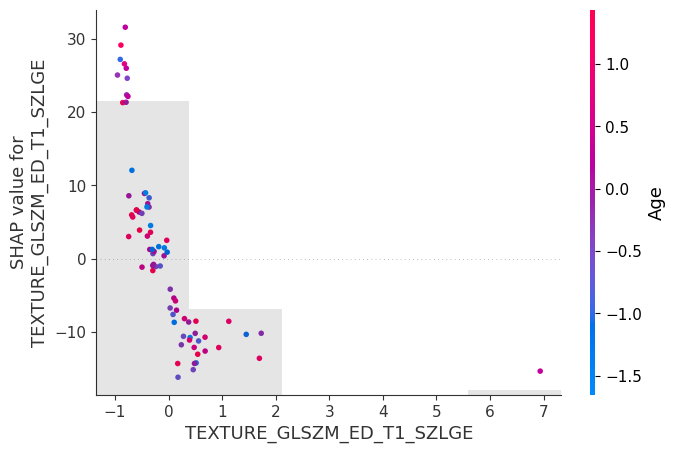

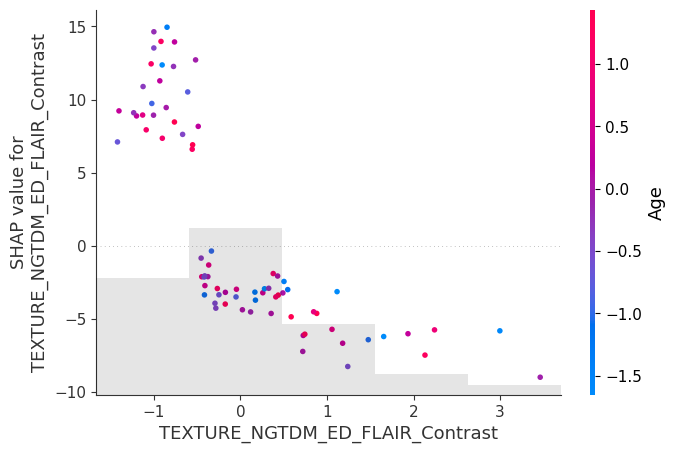

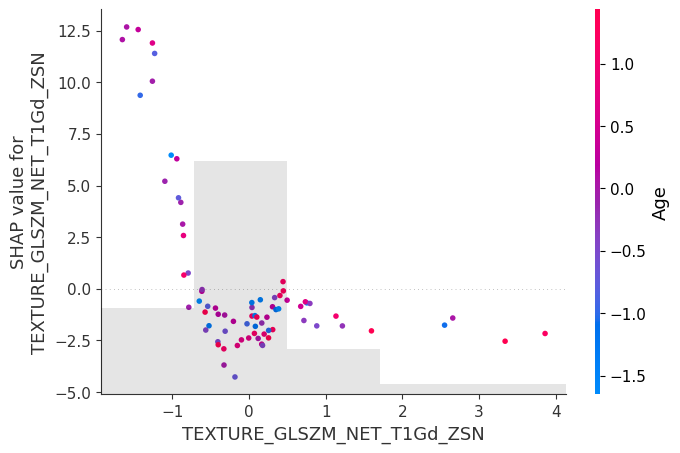

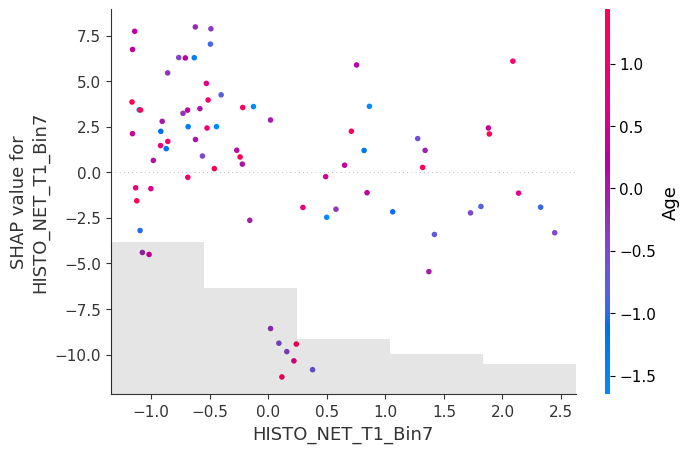

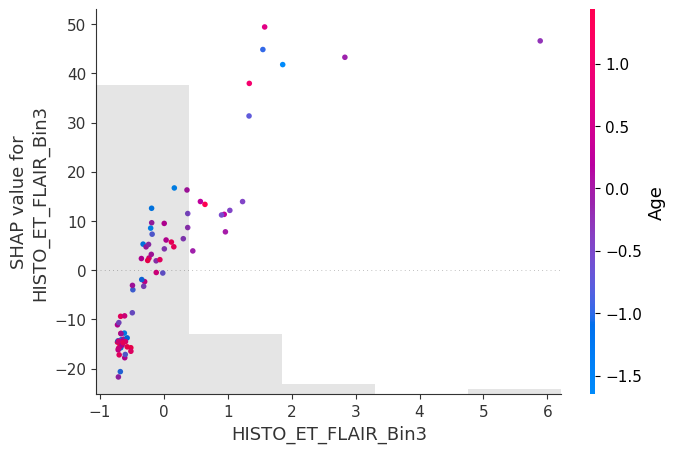

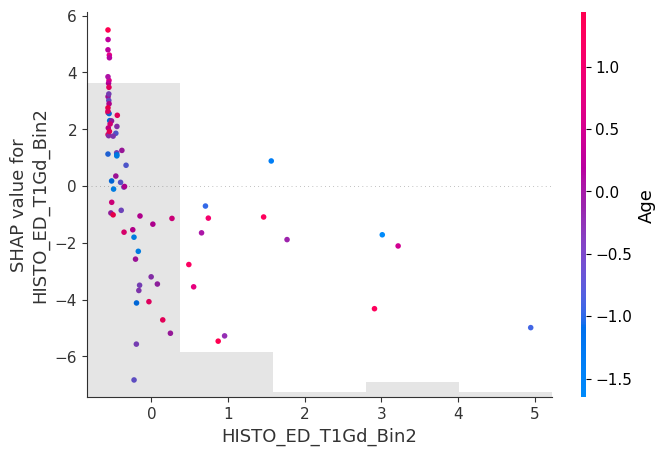

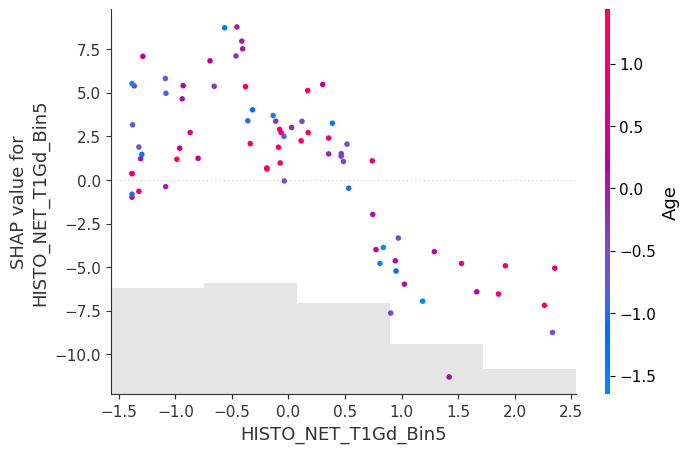

In [ ]:
for element in valid_columns:
  # Extract SHAP values for the current element (assuming column names match)
  shap_values_element = shap_values[:, element]

  shap.plots.scatter(shap_values_element, color=shap_values[:,"Age"])

  # Create SHAP scatter plot for the current element
  #shap.plots.scatter(shap_values_element)

  # Optional: Add a title or customize the plot using shap.plots.scatter arguments
  #shap.plots.scatter(shap_values_element, title=f"SHAP for {element}")

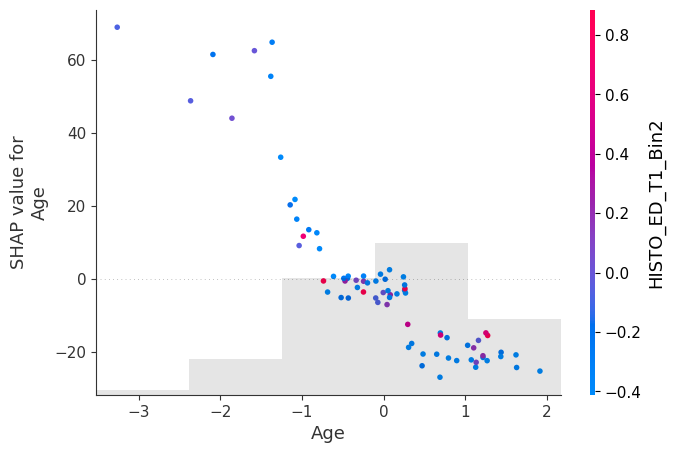

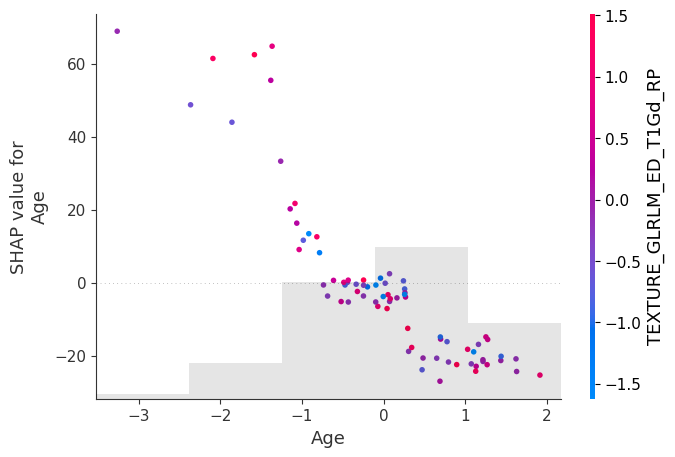

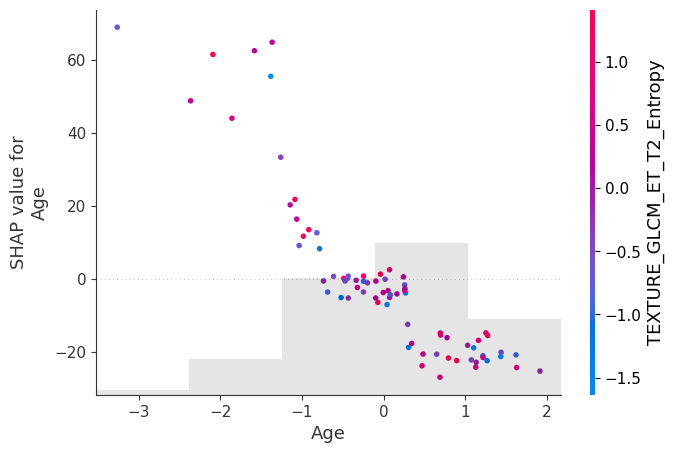

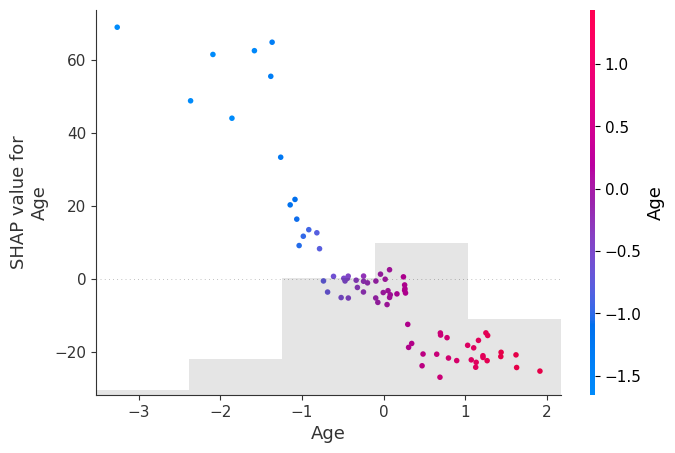

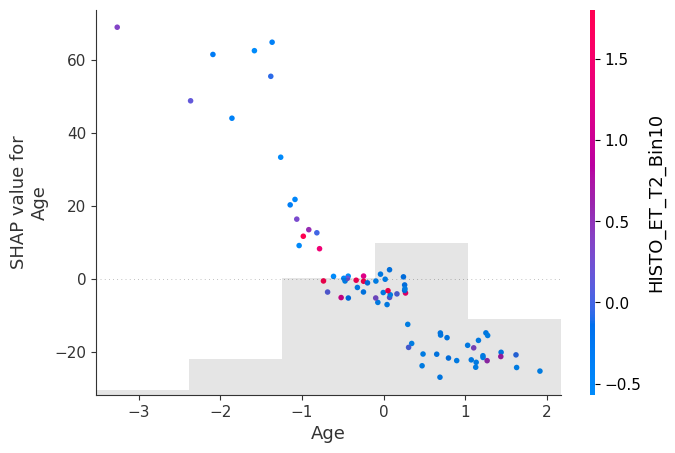

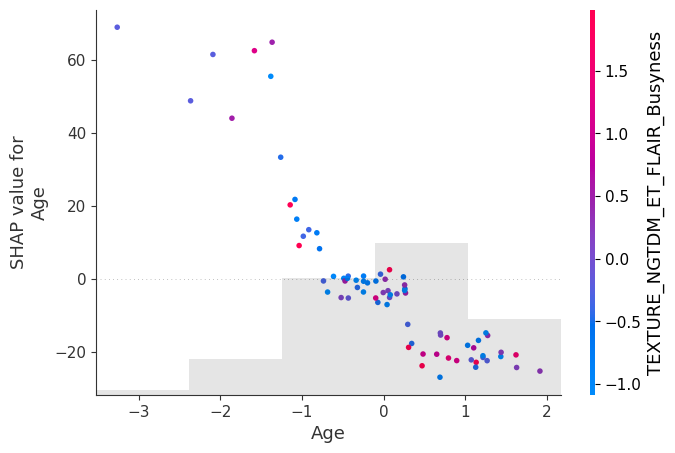

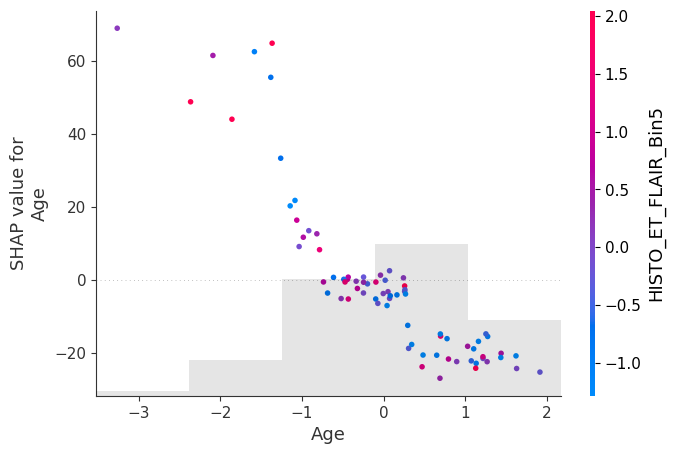

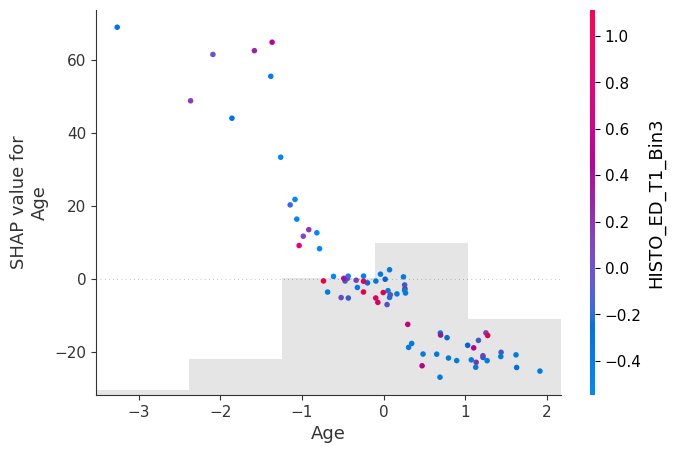

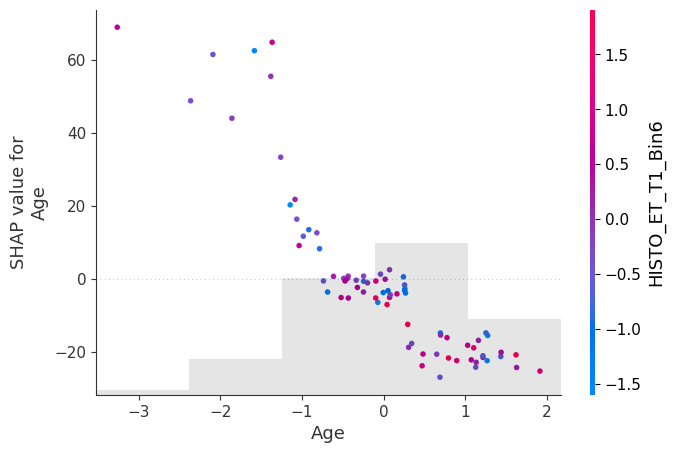

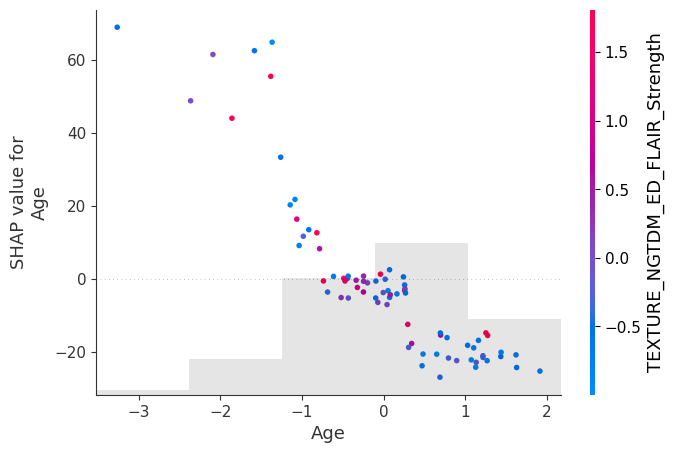

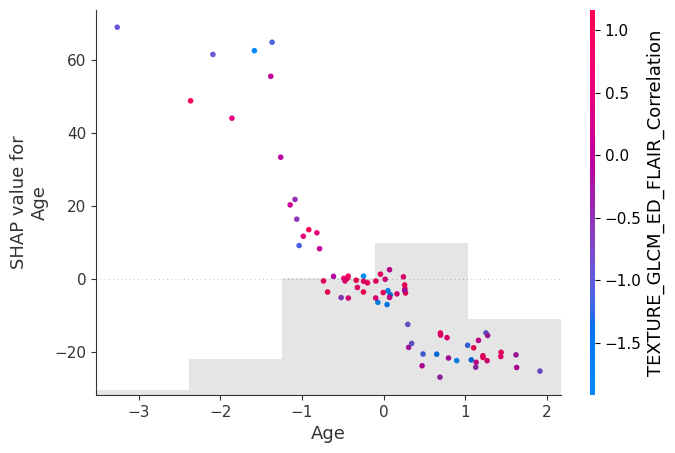

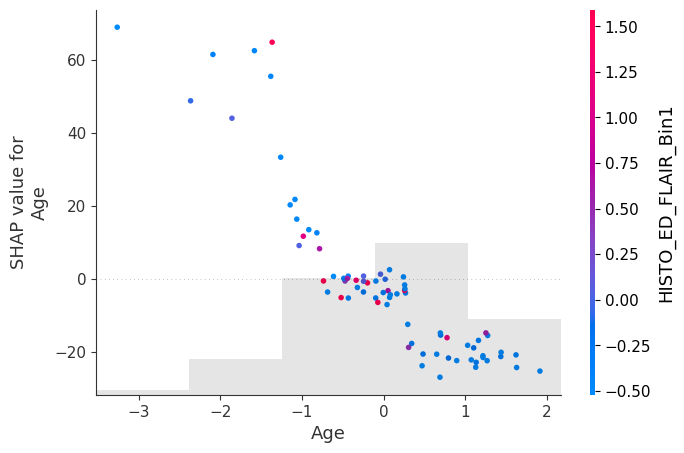

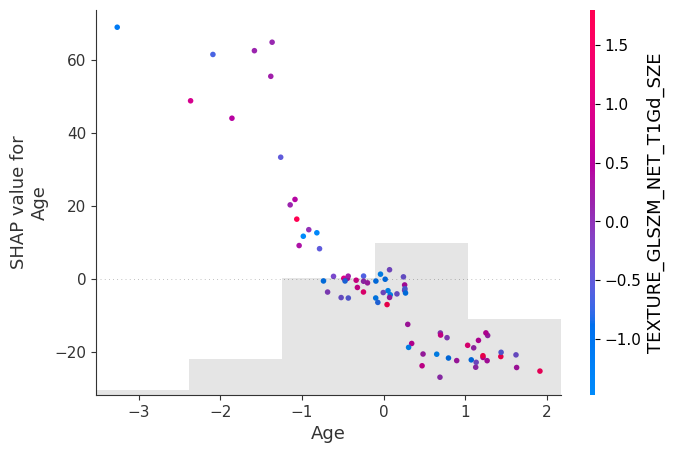

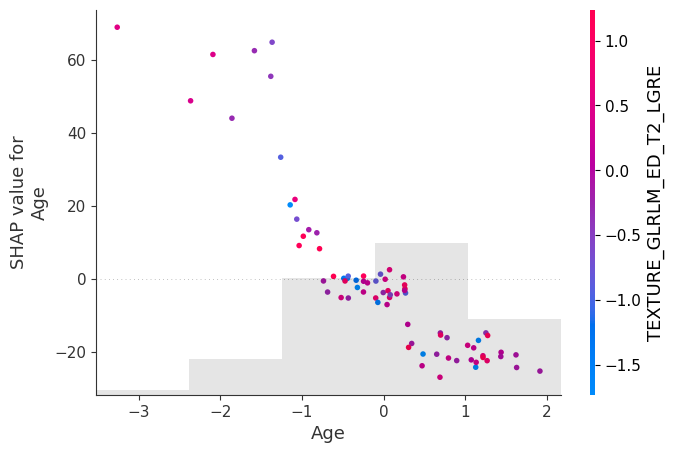

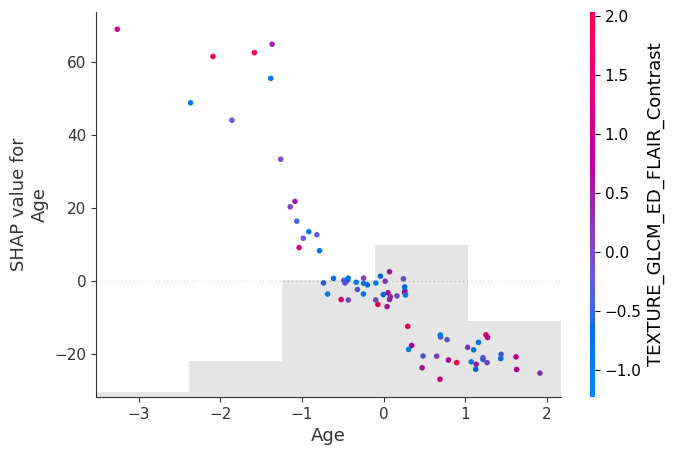

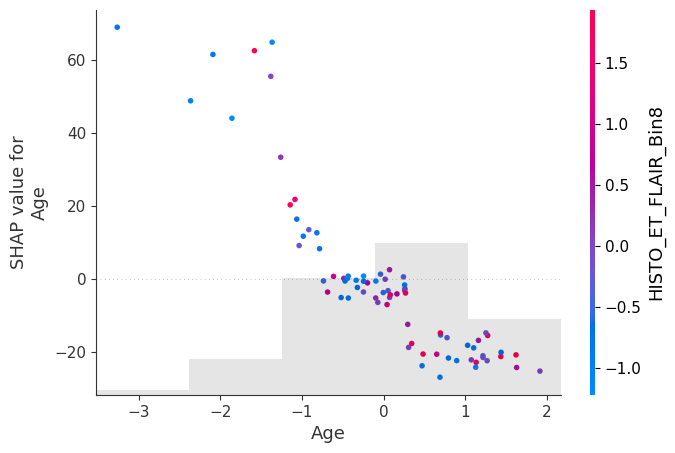

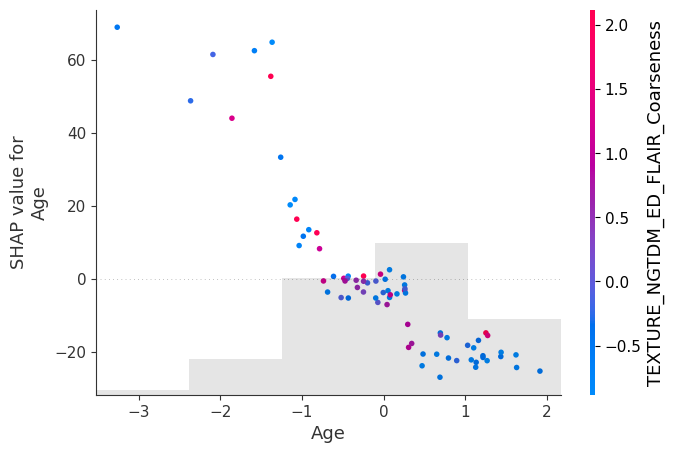

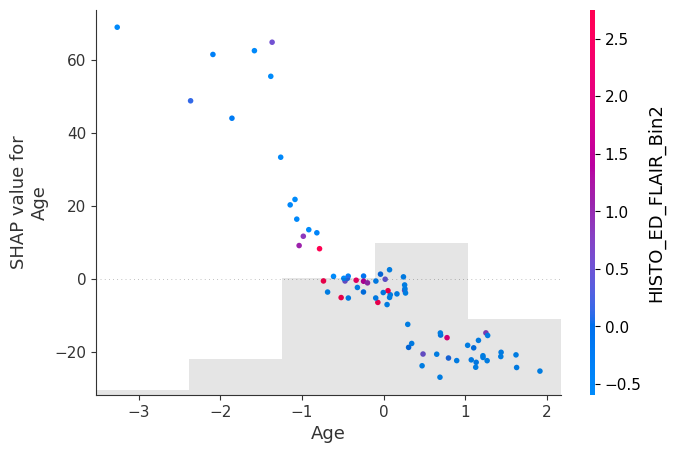

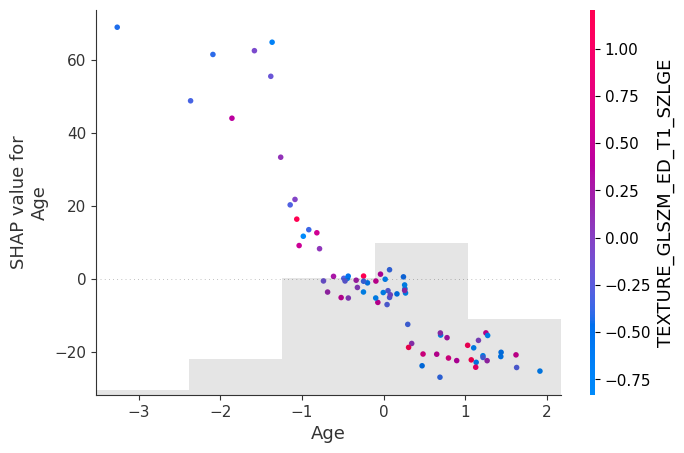

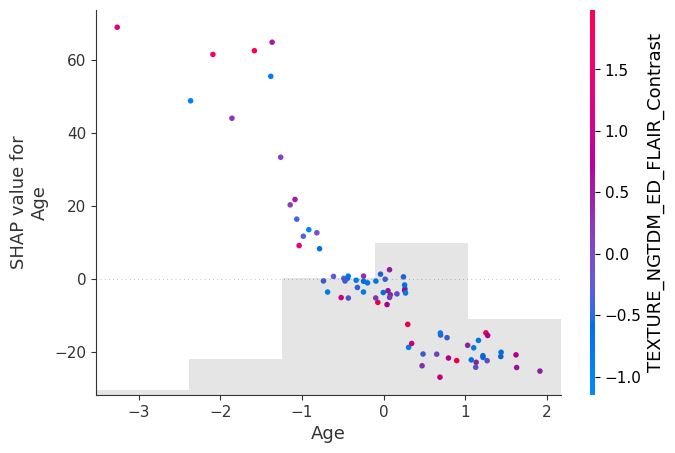

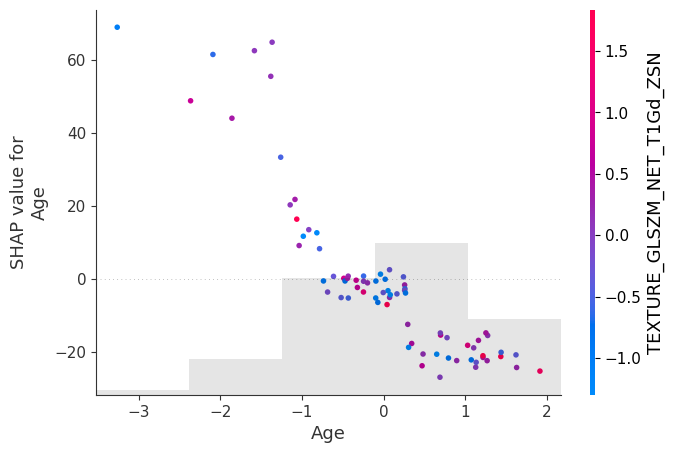

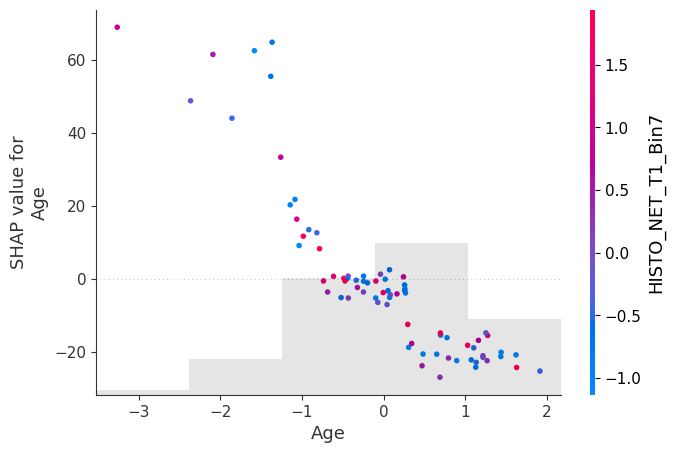

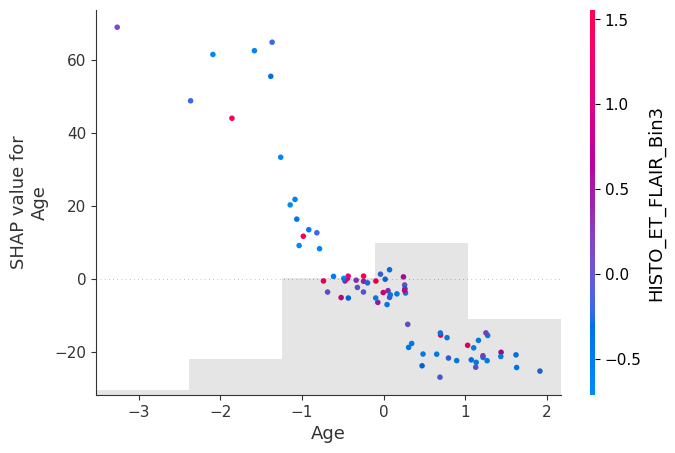

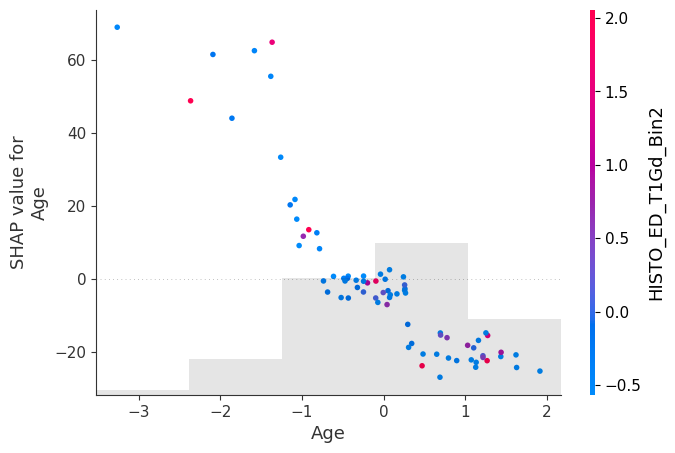

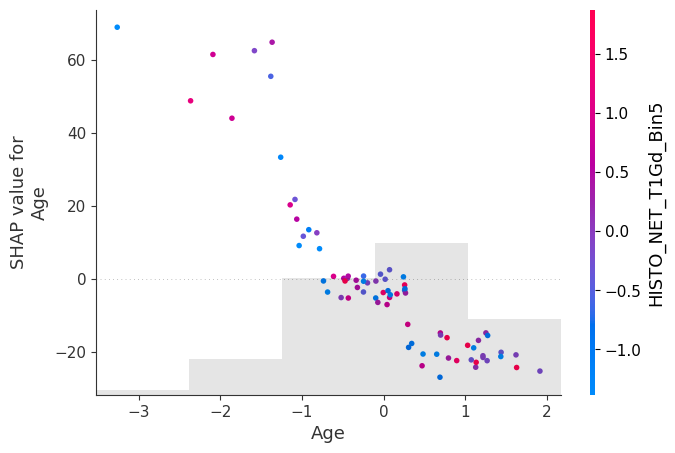

In [ ]:
for element in valid_columns:
  # Extract SHAP values for the current element (assuming column names match)
  shap_values_element = shap_values[:, element]

  shap.plots.scatter(shap_values[:,"Age"], color=shap_values_element)

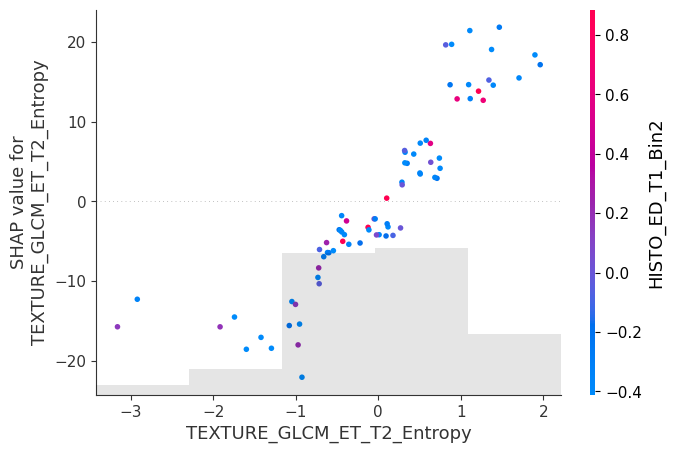

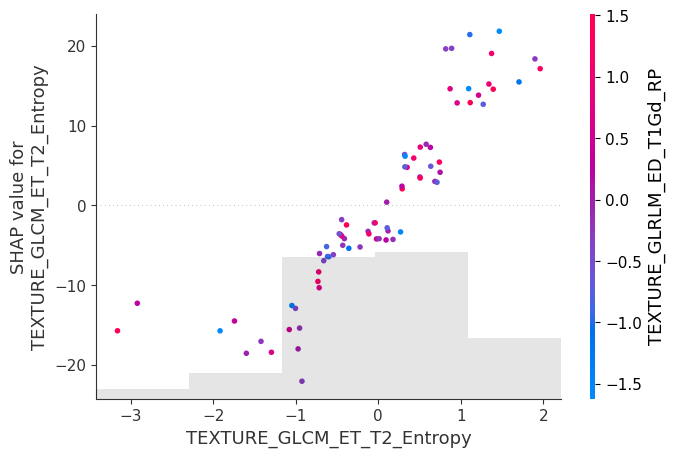

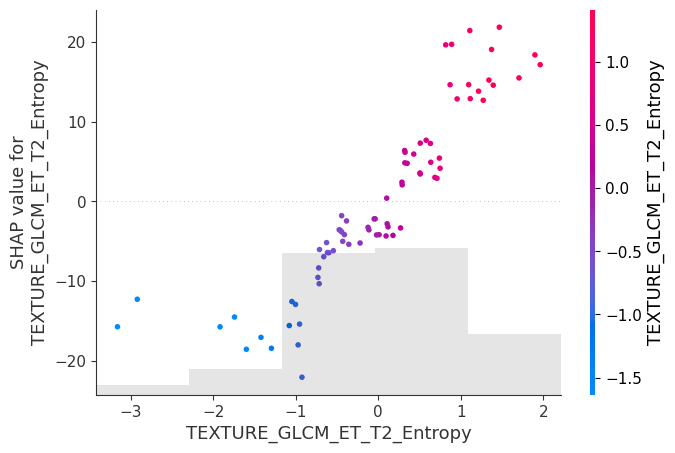

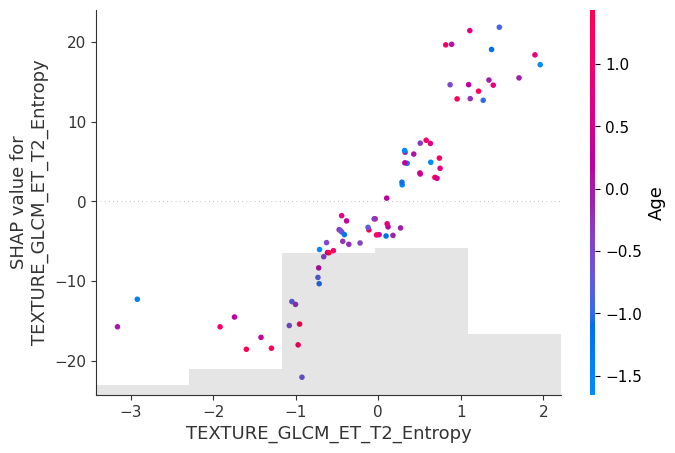

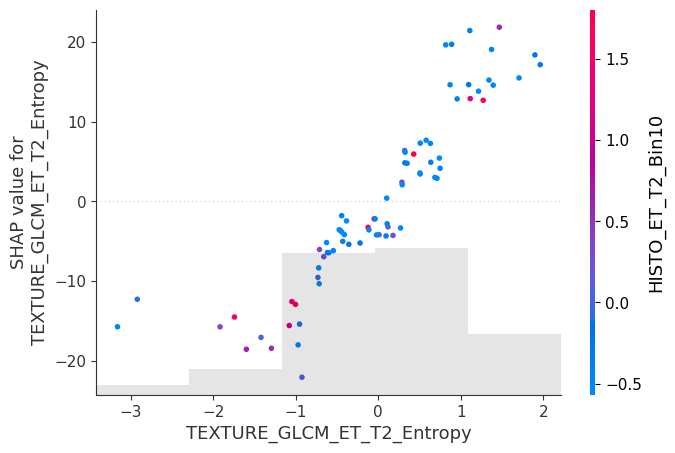

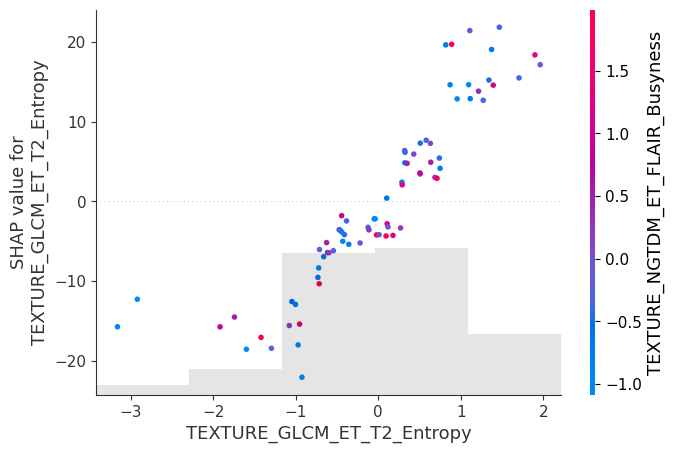

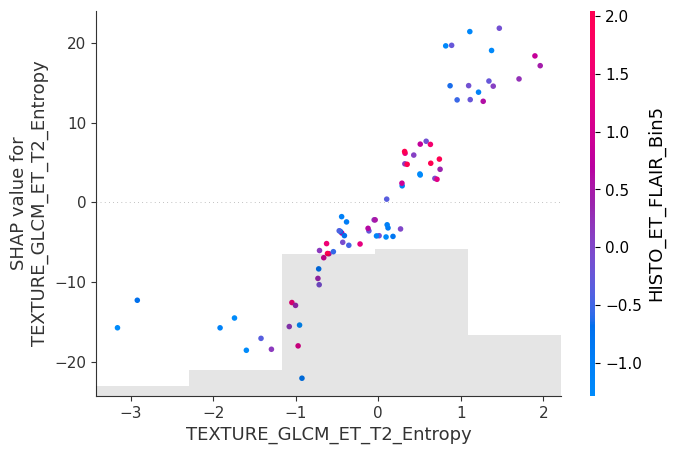

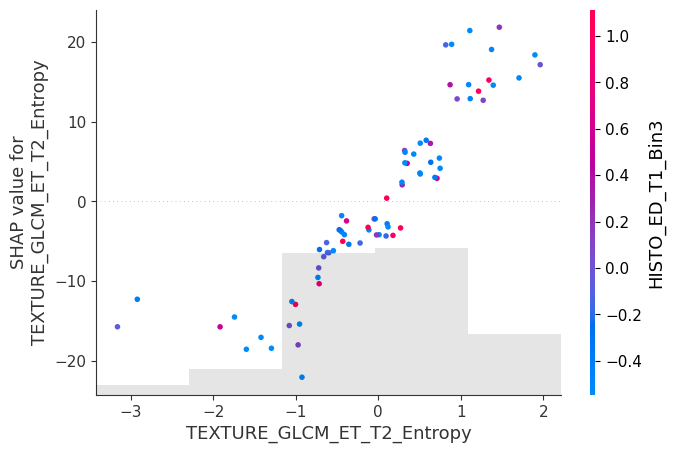

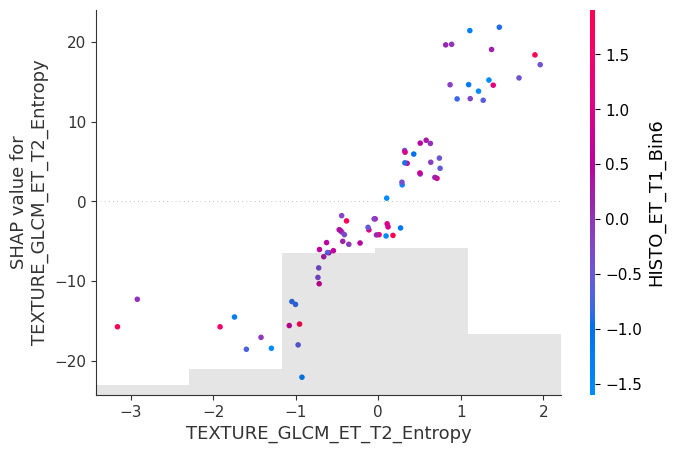

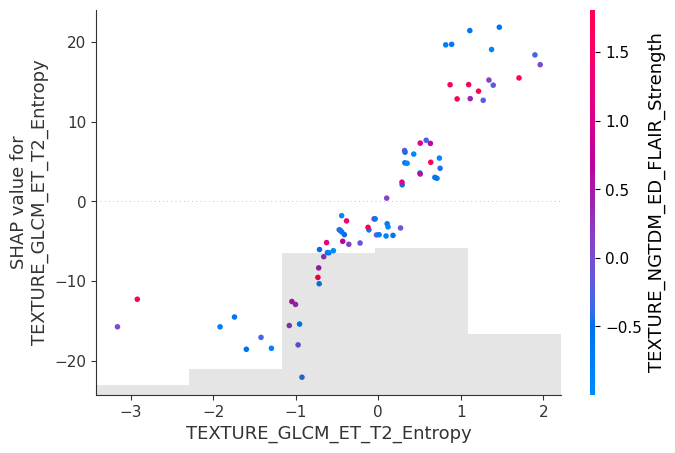

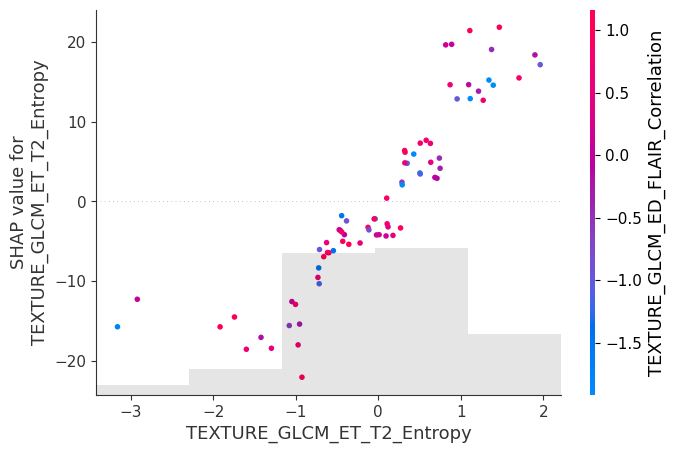

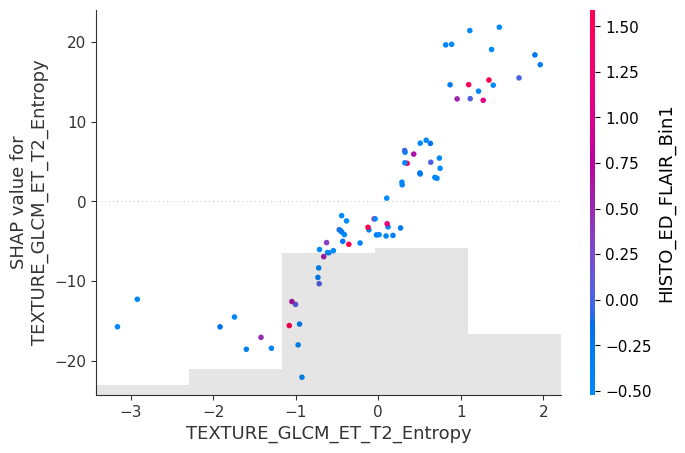

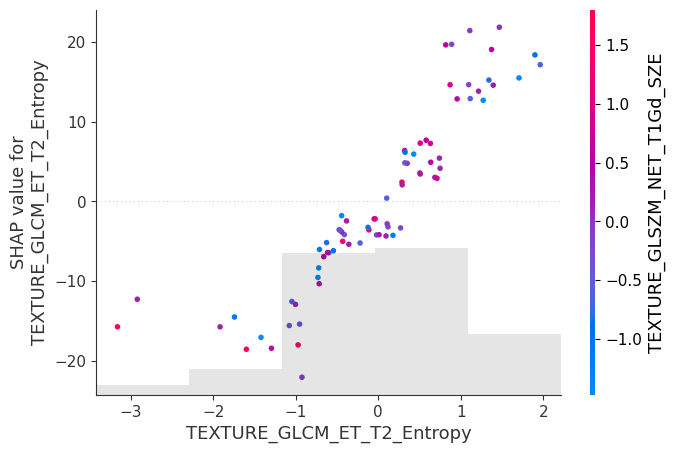

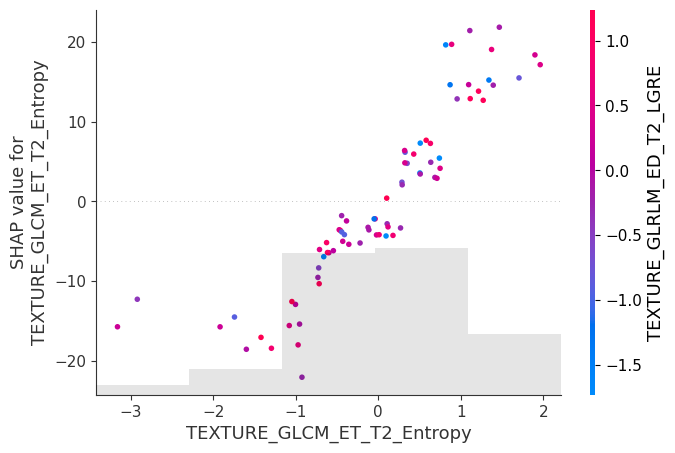

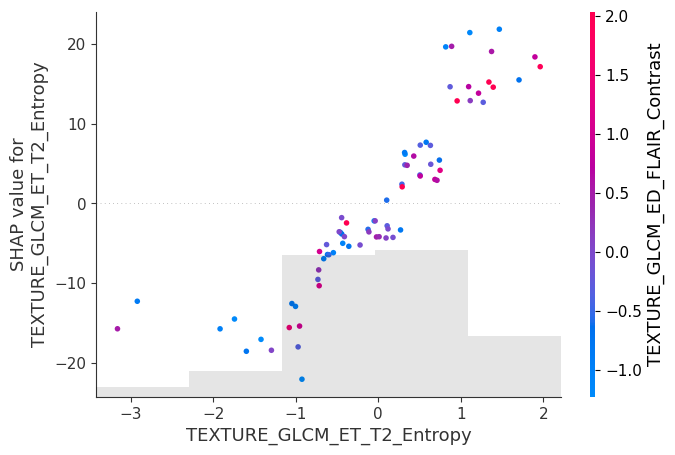

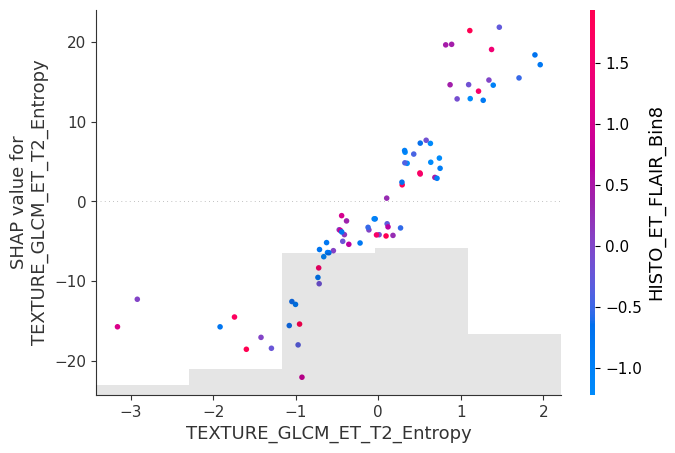

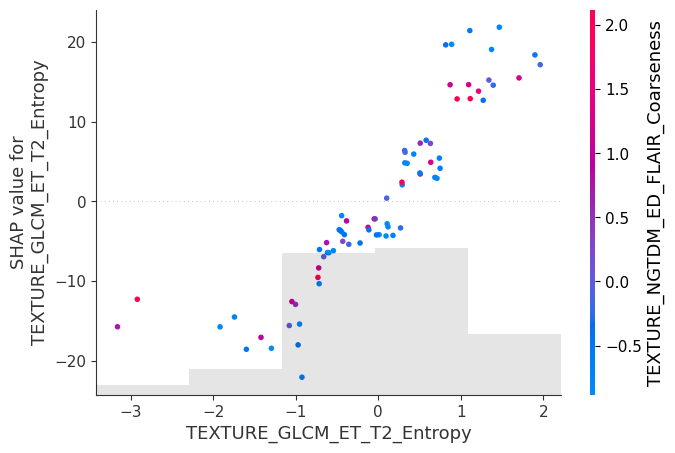

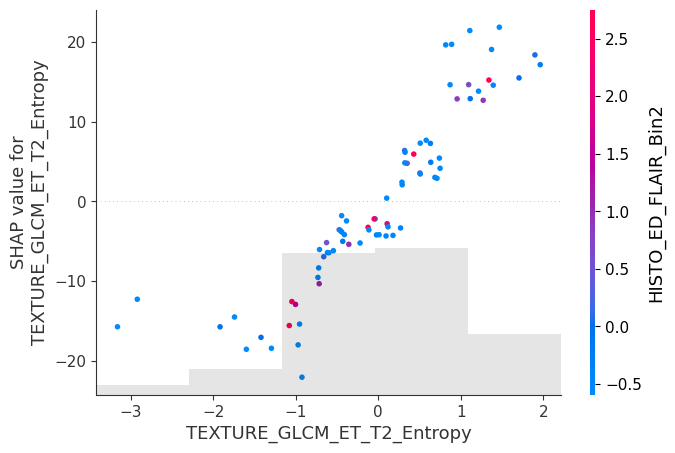

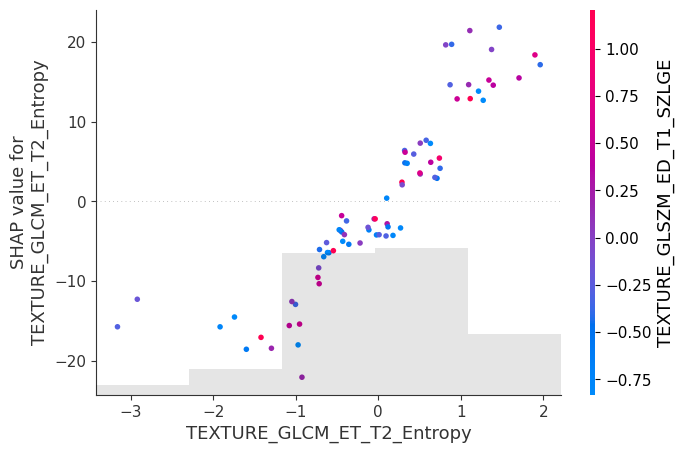

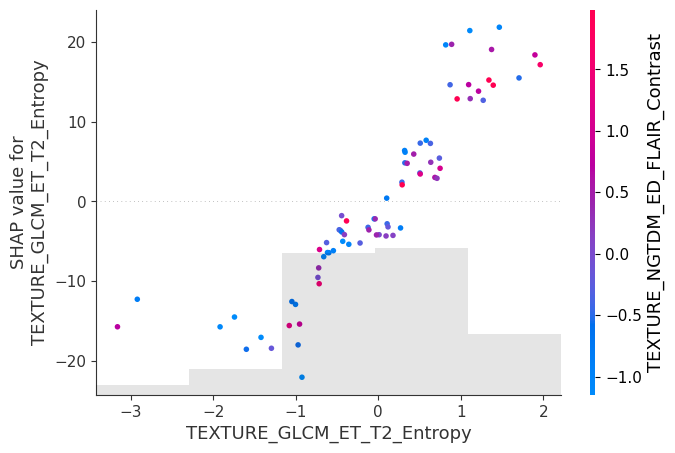

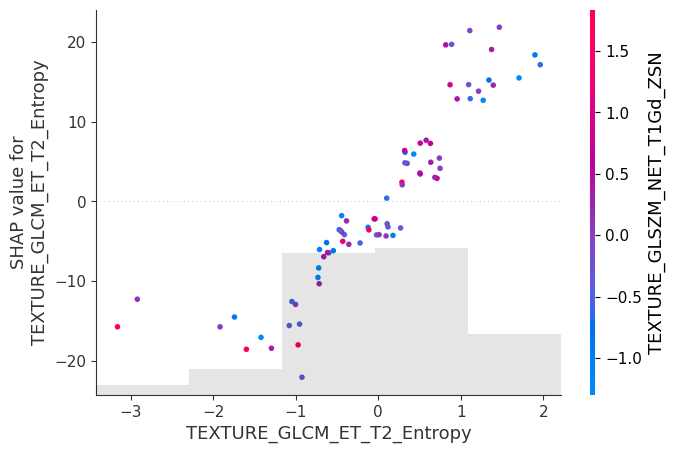

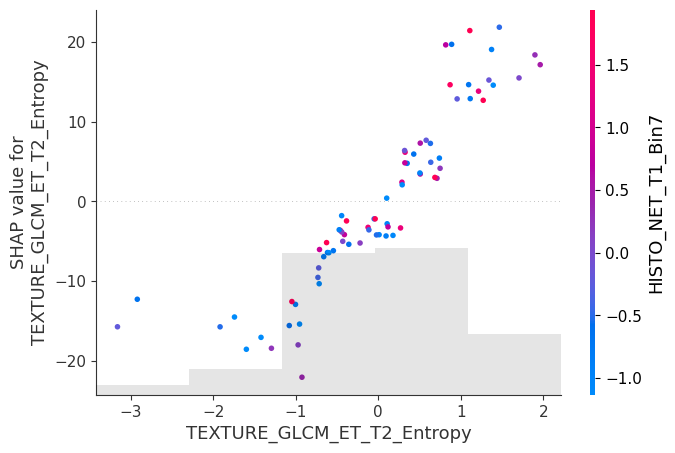

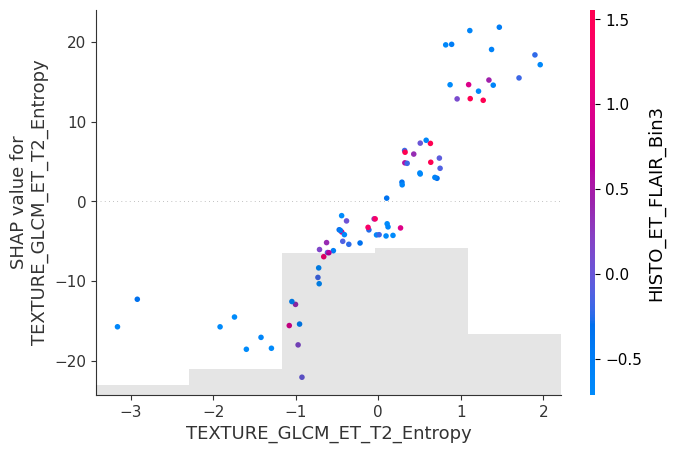

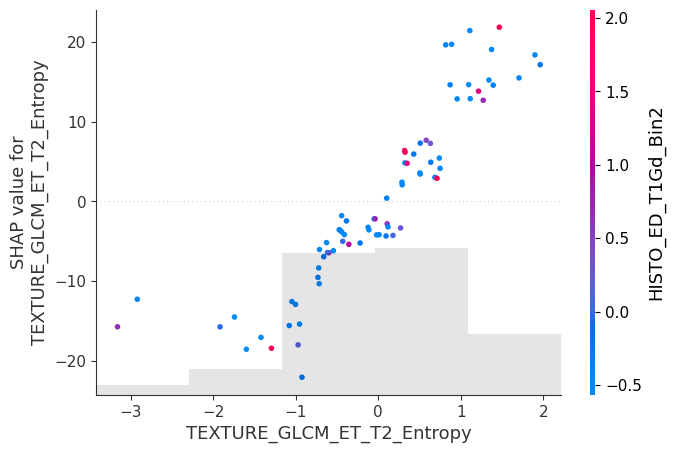

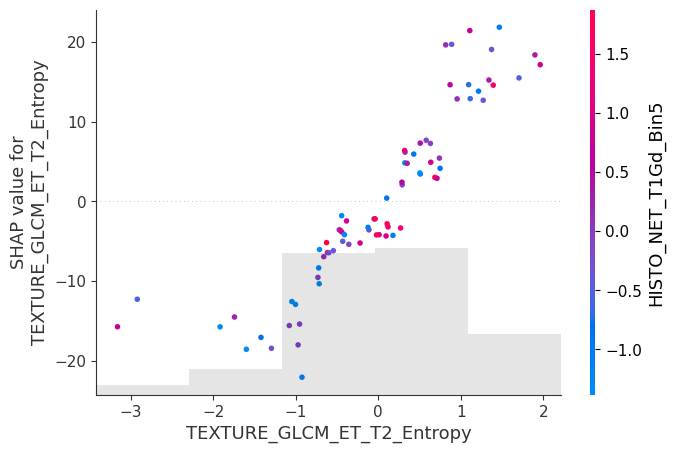

In [ ]:
for element in valid_columns:
  # Extract SHAP values for the current element (assuming column names match)
  shap_values_element = shap_values[:, element]

  shap.plots.scatter(shap_values[:,"TEXTURE_GLCM_ET_T2_Entropy"], color=shap_values_element)

  # Create SHAP scatter plot for the current element
  #shap.plots.scatter(shap_values_element)

  # Optional: Add a title or customize the plot using shap.plots.scatter arguments
  #shap.plots.scatter(shap_values_element, title=f"SHAP for {element}")

It seems that, if Age is higher it tends to decrease the SHAP values down, hence the Survival days is decreased.

But generally high T1 values tend to decrease the SHAP values even more.

**However, some pateints with very high SHAP for Age (that means their SD prediction's prominent feature is Age), tend to have higher T1 values.**

# Analysing Interactions with SHAP (Decision Tree - 25 features)

In [ ]:
explainer = shap.TreeExplainer(model_shap,feature_names=valid_columns)
shap_interaction = explainer.shap_interaction_values(selected_values)
shap_interaction.shape

(76, 25, 25)

It's 76 10x10 matices. These 10x10 matrices are contribution matrices.

In [ ]:
# SHAP interaction value for arbitory sample
pd.DataFrame(shap_interaction[0], index = valid_columns, columns = valid_columns)

HISTO_ED_T1_Bin2  TEXTURE_GLRLM_ED_T1Gd_RP  \
HISTO_ED_T1_Bin2                         -23.491566                  0.599132   
TEXTURE_GLRLM_ED_T1Gd_RP                   0.599132                 40.446867   
TEXTURE_GLCM_ET_T2_Entropy                -0.070559                 -0.573802   
Age                                       -0.228455                  1.005813   
HISTO_ET_T2_Bin10                          0.703757                 -0.345343   
TEXTURE_NGTDM_ET_FLAIR_Busyness            0.257360                  0.326326   
HISTO_ET_FLAIR_Bin5                        0.211336                 -0.249482   
HISTO_ED_T1_Bin3                          -0.059738                  0.267567   
HISTO_ET_T1_Bin6                           0.232394                  2.251914   
TEXTURE_NGTDM_ED_FLAIR_Strength            0.524165                 -0.846920   
TEXTURE_GLCM_ED_FLAIR_Correlation         -0.090661                 -0.827051   
HISTO_ED_FLAIR_Bin1                        0.171229                 -0.886771   
TEXTURE_GLSZM_NET_T1Gd_SZE                 0.036176                  0.014841   
TEXTURE_GLRLM_ED_T2_LGRE                   0.058014                 -0.601434   
TEXTURE_GLCM_ED_FLAIR_Contrast            -0.073832                  0.468474   
HISTO_ET_FLAIR_Bin8                        0.840242                 -0.790121   
TEXTURE_NGTDM_ED_FLAIR_Coarseness         -0.067555                  0.426715   
HISTO_ED_FLAIR_Bin2                       -0.092458                 -0.048140   
TEXTURE_GLSZM_ED_T1_SZLGE                 -0.090448                  0.907083   
TEXTURE_NGTDM_ED_FLAIR_Contrast            0.123015                 -0.285141   
TEXTURE_GLSZM_NET_T1Gd_ZSN                 0.022800                  0.128903   
HISTO_NET_T1_Bin7                          0.036118                  0.647898   
HISTO_ET_FLAIR_Bin3                       -0.223997                 -0.264170   
HISTO_ED_T1Gd_Bin2                         0.000936                  0.881179   
HISTO_NET_T1Gd_Bin5                        0.040980                 -0.127981   

                                   TEXTURE_GLCM_ET_T2_Entropy       Age  \
HISTO_ED_T1_Bin2                                    -0.070559 -0.228455   
TEXTURE_GLRLM_ED_T1Gd_RP                            -0.573802  1.005813   
TEXTURE_GLCM_ET_T2_Entropy                          -3.315549 -0.195173   
Age                                                 -0.195173 -1.259802   
HISTO_ET_T2_Bin10                                   -0.165236 -0.527946   
TEXTURE_NGTDM_ET_FLAIR_Busyness                      0.154998 -0.091319   
HISTO_ET_FLAIR_Bin5                                  0.091555  0.226970   
HISTO_ED_T1_Bin3                                     0.015393 -0.058153   
HISTO_ET_T1_Bin6                                    -0.057336  0.385432   
TEXTURE_NGTDM_ED_FLAIR_Strength                      0.286001  0.318813   
TEXTURE_GLCM_ED_FLAIR_Correlation                    0.675195 -0.036851   
HISTO_ED_FLAIR_Bin1                                  0.044727 -0.364399   
TEXTURE_GLSZM_NET_T1Gd_SZE                          -0.080996 -0.089003   
TEXTURE_GLRLM_ED_T2_LGRE                             0.058648 -0.081261   
TEXTURE_GLCM_ED_FLAIR_Contrast                      -0.104987  0.185285   
HISTO_ET_FLAIR_Bin8                                  0.214708  0.411872   
TEXTURE_NGTDM_ED_FLAIR_Coarseness                   -0.006145 -0.128313   
HISTO_ED_FLAIR_Bin2                                  0.042674 -0.052410   
TEXTURE_GLSZM_ED_T1_SZLGE                            0.229657 -0.164412   
TEXTURE_NGTDM_ED_FLAIR_Contrast                     -0.084608  0.294676   
TEXTURE_GLSZM_NET_T1Gd_ZSN                          -0.037801 -0.001202   
HISTO_NET_T1_Bin7                                    0.353349  0.427208   
HISTO_ET_FLAIR_Bin3                                 -0.007081 -0.442486   
HISTO_ED_T1Gd_Bin2                                   0.173258  0.072652   
HISTO_NET_T1Gd_Bin5                                  

Main effects are on the diagonal. The interaction effects are halved. This df + mean prediction == prediction

## Absolute Mean Plot

Remove the zero valued rows and columns

In [ ]:
# Get the absolute means of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df_mean_shap = pd.DataFrame(mean_shap, index = valid_columns, columns = valid_columns)

# Filter rows with at least one non-zero value
df_filtered = df_mean_shap.loc[(df_mean_shap != 0).any(axis=1)]

# Filter columns with at least one non-zero value
df_filtered = df_filtered.loc[:, (df_filtered != 0).any(axis=0)]

# Print the modified DataFrame
df_filtered



HISTO_ED_T1_Bin2  TEXTURE_GLRLM_ED_T1Gd_RP  \
HISTO_ED_T1_Bin2                          35.662880                  1.003414   
TEXTURE_GLRLM_ED_T1Gd_RP                   1.003414                 24.482804   
TEXTURE_GLCM_ET_T2_Entropy                 0.197934                  0.363013   
Age                                        0.592928                  0.957421   
HISTO_ET_T2_Bin10                          0.391294                  0.445615   
TEXTURE_NGTDM_ET_FLAIR_Busyness            0.185054                  0.245371   
HISTO_ET_FLAIR_Bin5                        0.277919                  0.171989   
HISTO_ED_T1_Bin3                           0.157404                  0.222562   
HISTO_ET_T1_Bin6                           0.340211                  2.024906   
TEXTURE_NGTDM_ED_FLAIR_Strength            0.548653                  0.923875   
TEXTURE_GLCM_ED_FLAIR_Correlation          0.185008                  0.343688   
HISTO_ED_FLAIR_Bin1                        0.061185                  0.308870   
TEXTURE_GLSZM_NET_T1Gd_SZE                 0.124314                  0.121737   
TEXTURE_GLRLM_ED_T2_LGRE                   0.111013                  0.481874   
TEXTURE_GLCM_ED_FLAIR_Contrast             0.176819                  0.231695   
HISTO_ET_FLAIR_Bin8                        0.348530                  0.269121   
TEXTURE_NGTDM_ED_FLAIR_Coarseness          0.285772                  0.470331   
HISTO_ED_FLAIR_Bin2                        0.063512                  0.115783   
TEXTURE_GLSZM_ED_T1_SZLGE                  0.220337                  0.513497   
TEXTURE_NGTDM_ED_FLAIR_Contrast            0.143213                  0.240526   
TEXTURE_GLSZM_NET_T1Gd_ZSN                 0.041605                  0.153286   
HISTO_NET_T1_Bin7                          0.104978                  0.274759   
HISTO_ET_FLAIR_Bin3                        0.196394                  0.293245   
HISTO_ED_T1Gd_Bin2                         0.133913                  0.295145   
HISTO_NET_T1Gd_Bin5                        0.084331                  0.152355   

                                   TEXTURE_GLCM_ET_T2_Entropy        Age  \
HISTO_ED_T1_Bin2                                     0.197934   0.592928   
TEXTURE_GLRLM_ED_T1Gd_RP                             0.363013   0.957421   
TEXTURE_GLCM_ET_T2_Entropy                           8.660465   0.313097   
Age                                                  0.313097  15.155827   
HISTO_ET_T2_Bin10                                    0.210962   0.265283   
TEXTURE_NGTDM_ET_FLAIR_Busyness                      0.088946   0.263493   
HISTO_ET_FLAIR_Bin5                                  0.102116   0.311526   
HISTO_ED_T1_Bin3                                     0.041642   0.210487   
HISTO_ET_T1_Bin6                                     0.190563   0.438813   
TEXTURE_NGTDM_ED_FLAIR_Strength                      0.475153   0.393139   
TEXTURE_GLCM_ED_FLAIR_Correlation                    0.520143   0.637698   
HISTO_ED_FLAIR_Bin1                                  0.045986   0.144246   
TEXTURE_GLSZM_NET_T1Gd_SZE                           0.155478   0.083067   
TEXTURE_GLRLM_ED_T2_LGRE                             0.183014   0.233954   
TEXTURE_GLCM_ED_FLAIR_Contrast                       0.218494   0.206156   
HISTO_ET_FLAIR_Bin8                                  0.291466   0.365411   
TEXTURE_NGTDM_ED_FLAIR_Coarseness                    0.125949   0.261656   
HISTO_ED_FLAIR_Bin2                                  0.117355   0.077015   
TEXTURE_GLSZM_ED_T1_SZLGE                            0.246270   0.506390   
TEXTURE_NGTDM_ED_FLAIR_Contrast                      0.148955   0.227893   
TEXTURE_GLSZM_NET_T1Gd_ZSN                           0.132314   0.062492   
HISTO_NET_T1_Bin7                                    0.175593   0.364453   
HISTO_ET_FLAIR_Bin3                                  0.237232   0.540610   
HISTO_ED_T1Gd_Bin2                                   0.229215   0.147574   
HISTO_NET_T1Gd_Bin5         

In [ ]:
# test this function properly
off_diagonal = df_filtered.where(~np.eye(25, dtype=bool)).stack()
off_diagonal

HISTO_ED_T1_Bin2     TEXTURE_GLRLM_ED_T1Gd_RP           1.003414
                     TEXTURE_GLCM_ET_T2_Entropy         0.197934
                     Age                                0.592928
                     HISTO_ET_T2_Bin10                  0.391294
                     TEXTURE_NGTDM_ET_FLAIR_Busyness    0.185054
                                                          ...   
HISTO_NET_T1Gd_Bin5  TEXTURE_NGTDM_ED_FLAIR_Contrast    0.063181
                     TEXTURE_GLSZM_NET_T1Gd_ZSN         0.057049
                     HISTO_NET_T1_Bin7                  0.145561
                     HISTO_ET_FLAIR_Bin3                0.642896
                     HISTO_ED_T1Gd_Bin2                 0.030450
Length: 600, dtype: float64

In [ ]:
result = pd.DataFrame({'Value': off_diagonal.values, 'Column Name': off_diagonal.index.get_level_values(1), 'Index Name': off_diagonal.index.get_level_values(0)})
result

Value                      Column Name           Index Name
0    1.003414         TEXTURE_GLRLM_ED_T1Gd_RP     HISTO_ED_T1_Bin2
1    0.197934       TEXTURE_GLCM_ET_T2_Entropy     HISTO_ED_T1_Bin2
2    0.592928                              Age     HISTO_ED_T1_Bin2
3    0.391294                HISTO_ET_T2_Bin10     HISTO_ED_T1_Bin2
4    0.185054  TEXTURE_NGTDM_ET_FLAIR_Busyness     HISTO_ED_T1_Bin2
..        ...                              ...                  ...
595  0.063181  TEXTURE_NGTDM_ED_FLAIR_Contrast  HISTO_NET_T1Gd_Bin5
596  0.057049       TEXTURE_GLSZM_NET_T1Gd_ZSN  HISTO_NET_T1Gd_Bin5
597  0.145561                HISTO_NET_T1_Bin7  HISTO_NET_T1Gd_Bin5
598  0.642896              HISTO_ET_FLAIR_Bin3  HISTO_NET_T1Gd_Bin5
599  0.030450               HISTO_ED_T1Gd_Bin2  HISTO_NET_T1Gd_Bin5

[600 rows x 3 columns]

In [ ]:
result = result.sort_values(by='Value', ascending=False)
result

Value                        Column Name  \
31   2.024906                   HISTO_ET_T1_Bin6   
193  2.024906           TEXTURE_GLRLM_ED_T1Gd_RP   
252  1.821407           TEXTURE_GLRLM_ED_T2_LGRE   
322  1.821407  TEXTURE_GLCM_ED_FLAIR_Correlation   
0    1.003414           TEXTURE_GLRLM_ED_T1Gd_RP   
..        ...                                ...   
492  0.022491         TEXTURE_GLSZM_NET_T1Gd_SZE   
310  0.019448                 HISTO_ED_T1Gd_Bin2   
564  0.019448         TEXTURE_GLSZM_NET_T1Gd_SZE   
396  0.008364         TEXTURE_GLSZM_NET_T1Gd_SZE   
303  0.008364  TEXTURE_NGTDM_ED_FLAIR_Coarseness   

                            Index Name  
31            TEXTURE_GLRLM_ED_T1Gd_RP  
193                   HISTO_ET_T1_Bin6  
252  TEXTURE_GLCM_ED_FLAIR_Correlation  
322           TEXTURE_GLRLM_ED_T2_LGRE  
0                     HISTO_ED_T1_Bin2  
..                                 ...  
492         TEXTURE_GLSZM_NET_T1Gd_ZSN  
310         TEXTURE_GLSZM_NET_T1Gd_SZE  
564                 HISTO_ED_T1Gd_Bin2  
396  TEXTURE_NGTDM_ED_FLAIR_Coarseness  
303         TEXTURE_GLSZM_NET_T1Gd_SZE  

[600 rows x 3 columns]

The above df represents the Mean SHAP interation values. Plot dependancy plots again with the higest interaction SHAP values.

## ABSOLUTE MEAN PLOT

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5]),
 [Text(0, 0.5, 'HISTO_ED_T1_Bin2'),
  Text(0, 1.5, 'TEXTURE_GLRLM_ED_T1Gd_RP'),
  Text(0, 2.5, 'TEXTURE_GLCM_ET_T2_Entropy'),
  Text(0, 3.5, 'Age'),
  Text(0, 4.5, 'HISTO_ET_T2_Bin10'),
  Text(0, 5.5, 'TEXTURE_NGTDM_ET_FLAIR_Busyness'),
  Text(0, 6.5, 'HISTO_ET_FLAIR_Bin5'),
  Text(0, 7.5, 'HISTO_ED_T1_Bin3'),
  Text(0, 8.5, 'HISTO_ET_T1_Bin6'),
  Text(0, 9.5, 'TEXTURE_NGTDM_ED_FLAIR_Strength'),
  Text(0, 10.5, 'TEXTURE_GLCM_ED_FLAIR_Correlation'),
  Text(0, 11.5, 'HISTO_ED_FLAIR_Bin1'),
  Text(0, 12.5, 'TEXTURE_GLSZM_NET_T1Gd_SZE'),
  Text(0, 13.5, 'TEXTURE_GLRLM_ED_T2_LGRE'),
  Text(0, 14.5, 'TEXTURE_GLCM_ED_FLAIR_Contrast'),
  Text(0, 15.5, 'HISTO_ET_FLAIR_Bin8'),
  Text(0, 16.5, 'TEXTURE_NGTDM_ED_FLAIR_Coarseness'),
  Text(0, 17.5, 'HISTO_ED_FLAIR_Bin2'),
  Text(0, 18.5, 'TEXTURE_GLSZM_ED_T1_SZLGE'),
  Text(0

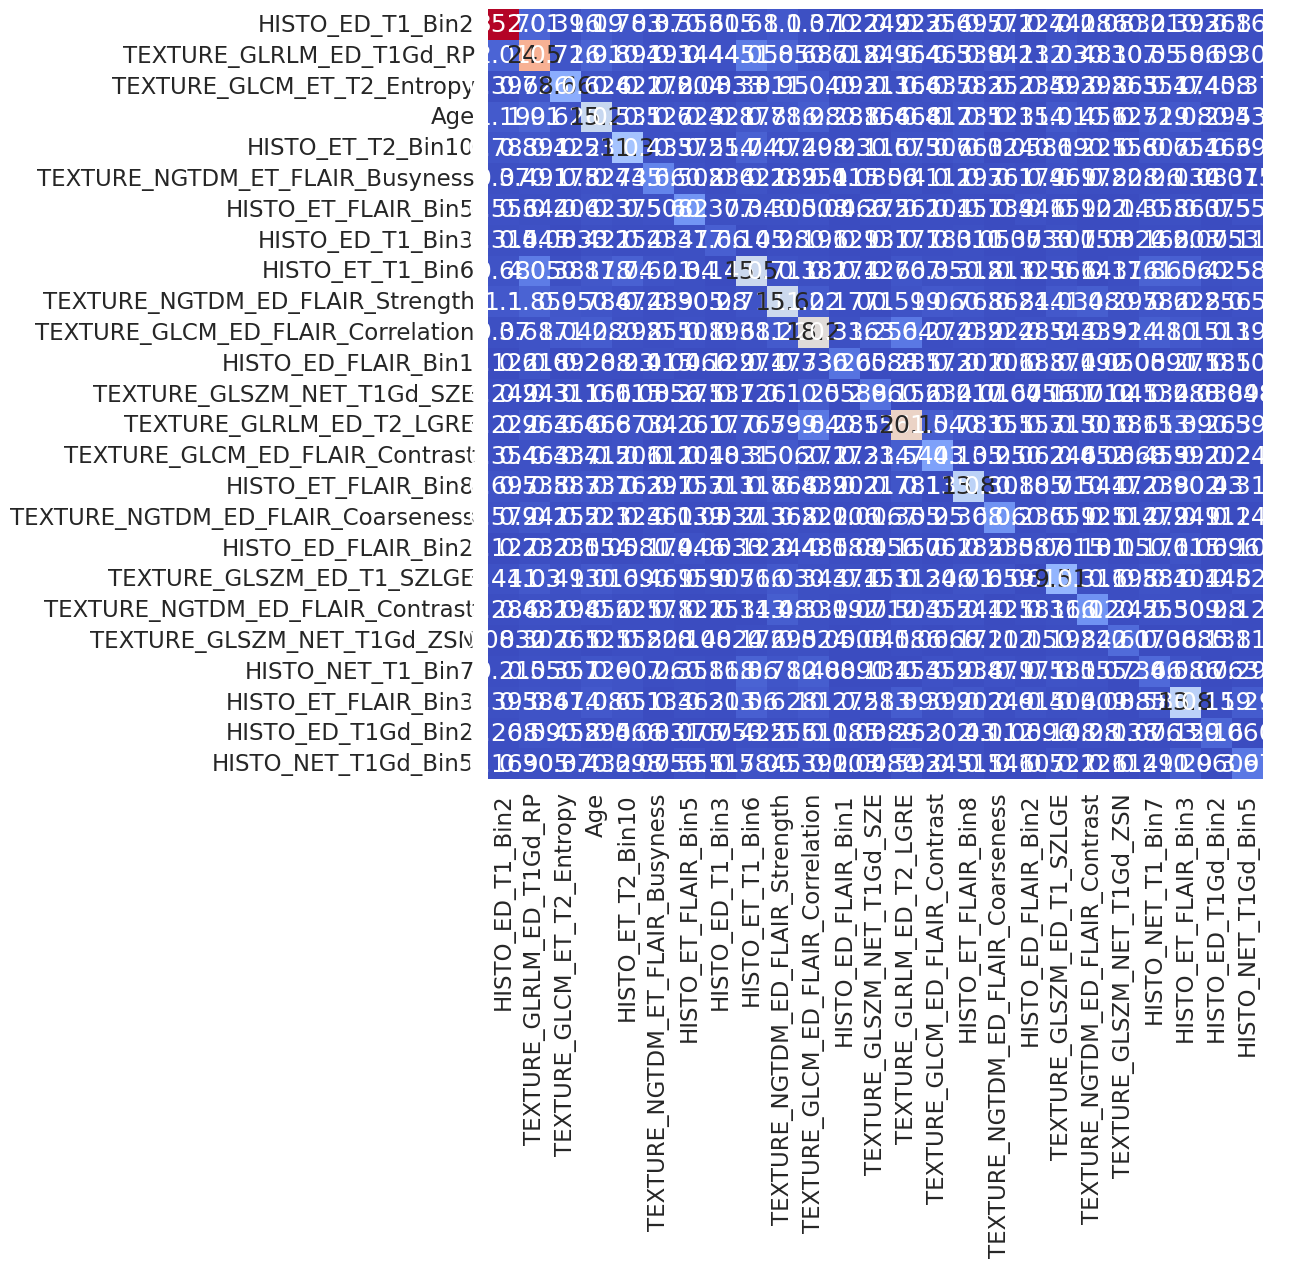

In [ ]:
# since interaction effects are halved
df_filtered.where(df_filtered.values == np.diagonal(df_filtered), df_filtered.values*2, inplace = True)

#display
plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
sns.set(font_scale = 1.5)
sns.heatmap(df_filtered, cmap='coolwarm', annot=True, fmt='.3g', cbar=False)
plt.yticks(rotation=0)


Can see some several different interactions above. --> Check with dependance plots <br>
(0,1) - 40.1<br>
(1,2) - 104<br>
(1,9) - 39.3<br>
(2,4) - 17.8<br>
(4,6) - 39.6<br>
(4,7) - 60.2<br>
(4,9) - 40.2<br>
(6,7) - 29.8<br>
(6,9) - 28.4<br>
(7,9) - 32.1<br>


## SHAP interaction beeswarm plot

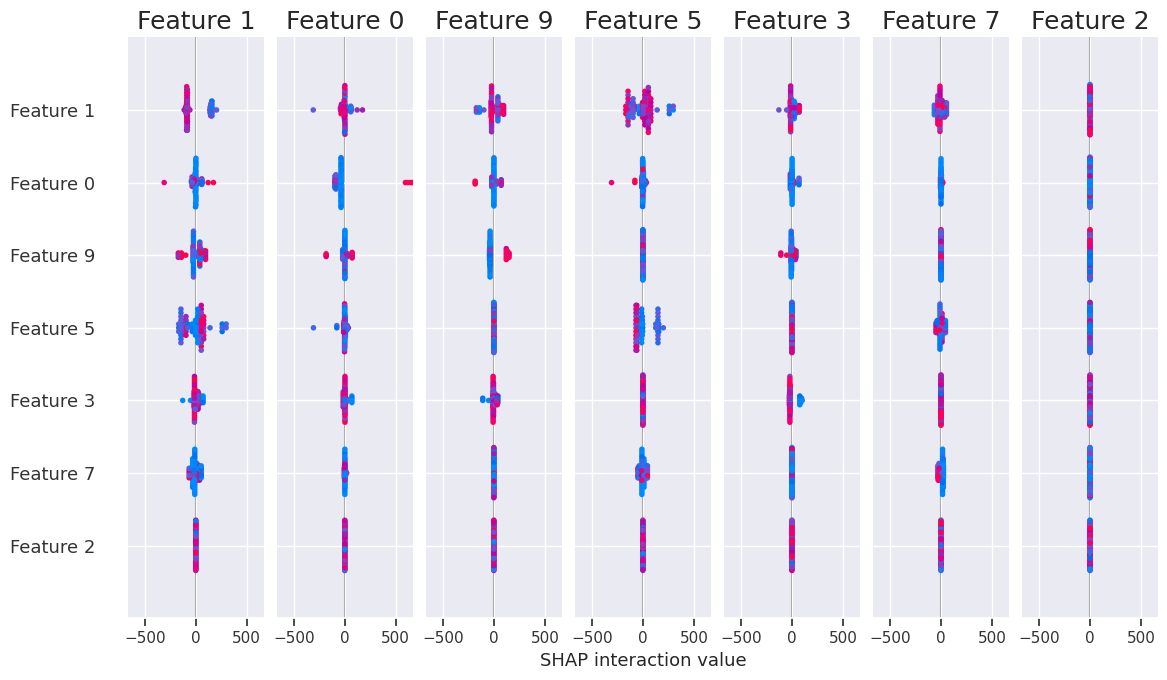

In [ ]:
shap.summary_plot(shap_interaction, selected_values)

(Error popped in above cell when using feature names)

Above plot depicts that, main effects 9, 4, 7 are negative.

Meanwhile, main effects 6, 1 & 2 are positive.

## Dependace plots

**These plots are only for the interaction effects. The relationships should be considered in light of the main effects of bothe features**

**If main effects and interaction effects both work in the same direction, the predictions also work in the same direction. But if they work in the opposite direction then there is no conclusion to the prediction ?**

In [ ]:
# helper function to find the features
def find_string_index(string_list, target_string):
  """
  This function finds the index of a specific string in a list of unique strings.

  Args:
      string_list: A list of unique strings.
      target_string: The string to find the index of.

  Returns:
      The index of the target_string in the list, or -1 if not found.
  """

  try:
    return string_list.index(target_string)
  except ValueError:
    return -1

#### HISTO_ET_T1_Bin6	TEXTURE_GLRLM_ED_T1Gd_RP

In [ ]:
find_string_index(valid_columns, 'HISTO_ET_T1_Bin6')

8

In [ ]:
find_string_index(valid_columns, 'TEXTURE_GLRLM_ED_T1Gd_RP')

1

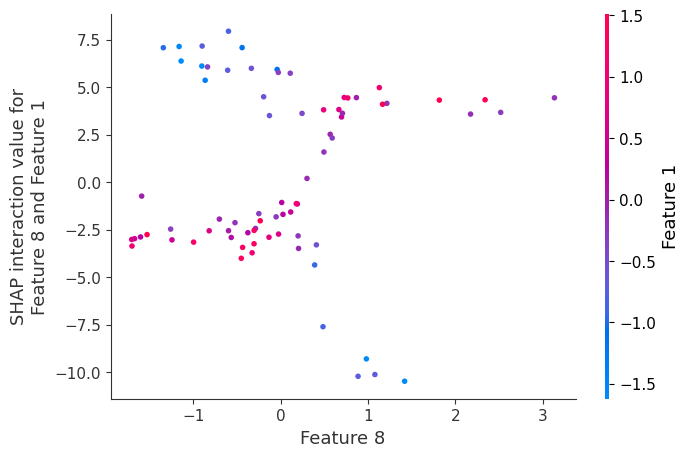

In [ ]:
shap.dependence_plot(
                    ("Feature 8","Feature 1"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

#### TEXTURE_GLRLM_ED_T2_LGRE	TEXTURE_GLCM_ED_FLAIR_Correlation

In [ ]:
find_string_index(valid_columns, 'TEXTURE_GLRLM_ED_T2_LGRE')

13

In [ ]:
find_string_index(valid_columns, 'TEXTURE_GLCM_ED_FLAIR_Correlation')

10

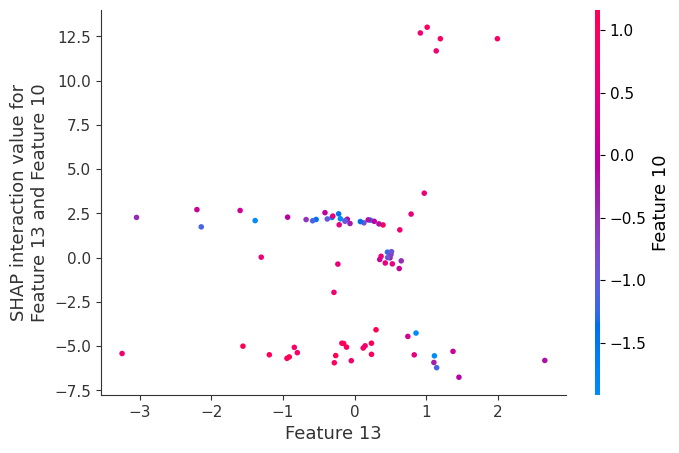

In [ ]:
shap.dependence_plot(
                    ("Feature 13","Feature 10"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

#### TEXTURE_GLRLM_ED_T1Gd_RP	HISTO_ED_T1_Bin2

In [ ]:
find_string_index(valid_columns, 'TEXTURE_GLRLM_ED_T1Gd_RP')

1

In [ ]:
find_string_index(valid_columns, 'HISTO_ED_T1_Bin2')

0

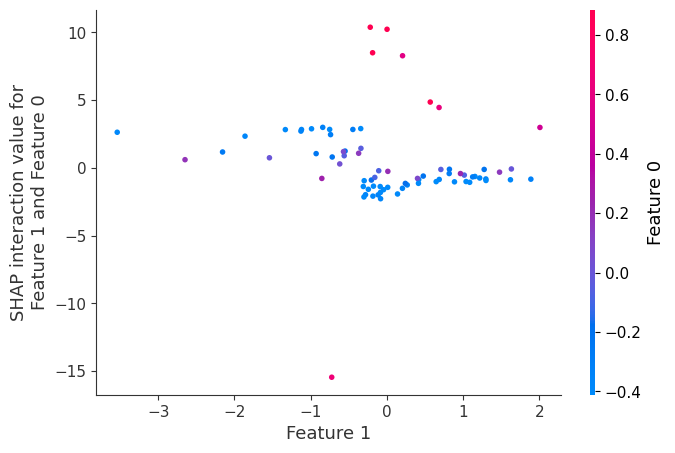

In [ ]:
shap.dependence_plot(
                    ("Feature 1","Feature 0"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

#### TEXTURE_GLRLM_ED_T1Gd_RP	Age

In [ ]:
find_string_index(valid_columns, 'TEXTURE_GLRLM_ED_T1Gd_RP')

1

In [ ]:
find_string_index(valid_columns, 'Age')

3

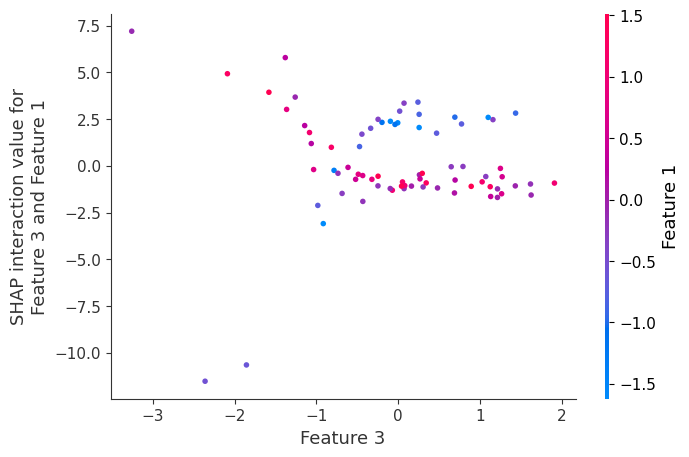

In [ ]:
shap.dependence_plot(
                    ("Feature 3","Feature 1"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

### 	HISTO_NET_T1_Bin7	HISTO_ET_T1_Bin6

In [ ]:
find_string_index(valid_columns, 'HISTO_NET_T1_Bin7')

21

In [ ]:
find_string_index(valid_columns, 'HISTO_ET_T1_Bin6')

8

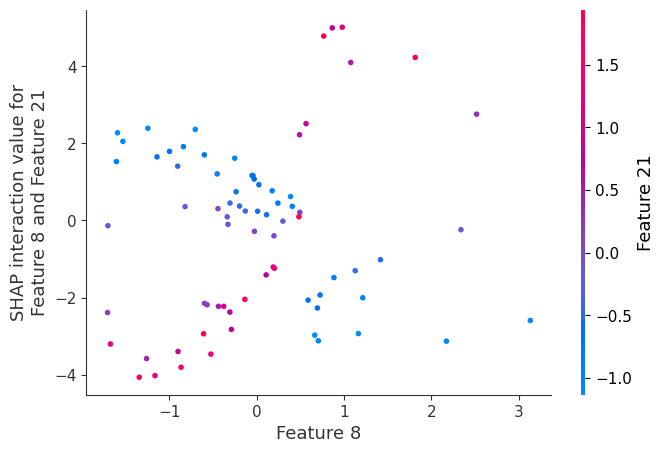

In [ ]:
shap.dependence_plot(
                    ("Feature 8","Feature 21"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)

#### TEXTURE_NGTDM_ED_FLAIR_Strength	TEXTURE_GLRLM_ED_T1Gd_RP

In [ ]:
find_string_index(valid_columns, 'TEXTURE_NGTDM_ED_FLAIR_Strength')

9

In [ ]:
find_string_index(valid_columns, 'TEXTURE_GLRLM_ED_T1Gd_RP')

1

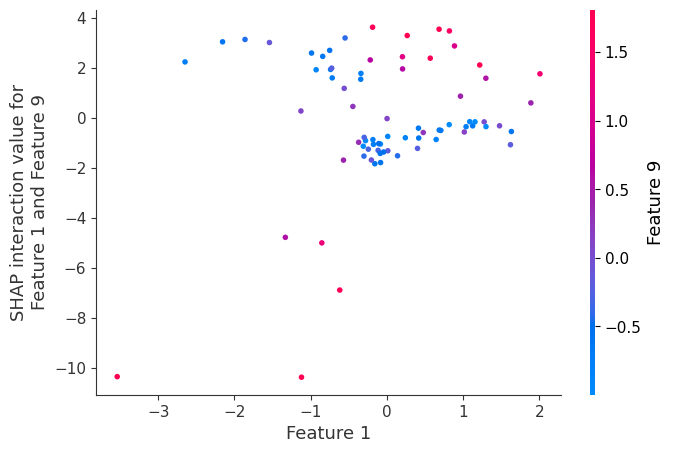

In [ ]:
shap.dependence_plot(
                    ("Feature 1","Feature 9"),
                    shap_interaction,
                    selected_values,
                    display_features = selected_values)